In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

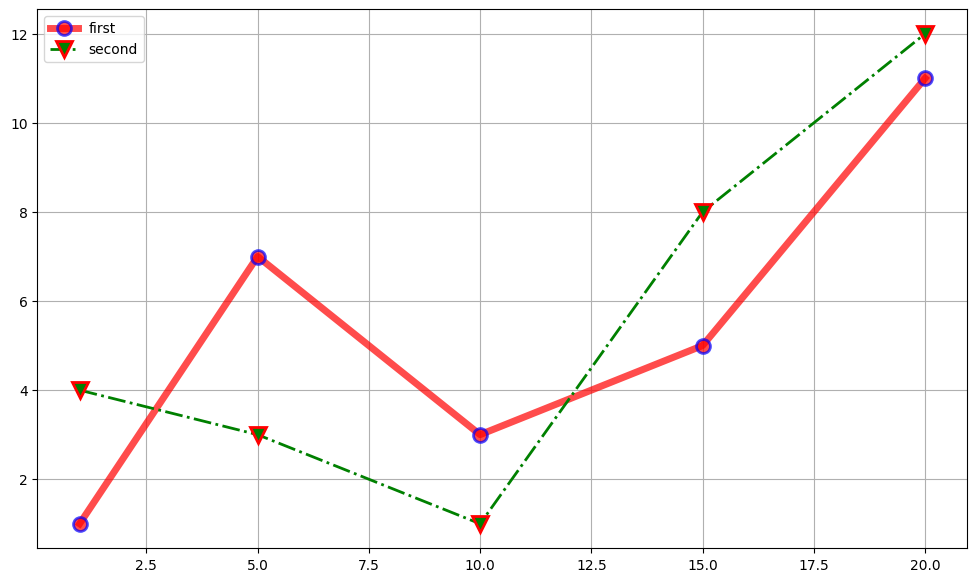

In [2]:
x = [1, 5, 10, 15, 20]
y1 = [1, 7, 3, 5, 11]
y2 = [4, 3, 1, 8, 12]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torchmetrics.text import WordErrorRate
from torchvision.io import read_image
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
from torchvision.models import EfficientNet_V2_M_Weights, efficientnet_v2_m, EfficientNet_V2_S_Weights, efficientnet_v2_s
import numpy as np
import shutil
from collections import defaultdict
from functools import partial
from itertools import chain
import os
import json
import copy
import typing
from typing import Optional
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sacrebleu import corpus_bleu
from collections import defaultdict
from accelerate import Accelerator
from PIL import Image
import re
import math

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing

os.environ["TOKENIZERS_PARALLELISM"] = "true"

C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# фиксации параметров в рамках всего запуска
def seed_everything(seed: int) -> None:
    import os
    import random
    import torch
    import numpy as np

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def seed_worker(worker_id):
    import random
    import numpy as np
    import torch
    
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 13
seed_everything(SEED)

import torch
g = torch.Generator()
g.manual_seed(0)

# accelerator = Accelerator(mixed_precision="no", cpu=True)
accelerator = Accelerator(mixed_precision="no")

device = accelerator.device
print(device)

cuda


In [5]:
def get_target(data_dir: Path,
               le: typing.Optional[LabelEncoder] = None,
               label_encoder_pickle_file: Path = Path.cwd() / "data" / "labelencoder.pkl",
               feedbacks : bool = True,
               level : int = 1,
               category1: str = None,
               category2: str = None,
               category3: str = None,
               category4: str = None,
               ):

    folders = os.listdir(data_dir)
    
    if level not in range(1,6):
        raise ValueError("The value of 'level' must be 1, 2, 3, 4 or 5")
    
    if level == 1:
        categories = folders

    elif level == 2:
        if category1 is None:
            raise TypeError("choose_category() missing 1 required positional argument: 'category1'")
        categories = [category for category in folders if category.split("_")[0]==category1]

    elif level == 3:
        if category1 is None or category2 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1' or 'category2'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2)]

    elif level == 4:
        if category1 is None or category2 is None or category3 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2' or 'category3'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3)]

    elif level == 5:
        if category1 is None or category2 is None or category3 is None  or category4 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2', 'category3' or 'category4'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3) and (category.split("_")[3]==category4)]
    
    if feedbacks:
        paths_card = [data_dir / category / "card" for category in categories]
        paths_feedbacks = [data_dir / category / "feedbacks" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card + paths_feedbacks]
        img_paths = list(chain(*img_paths))
    else:
        paths_card = [data_dir / category / "card" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card]
        img_paths = list(chain(*img_paths))
    
    target = ["_".join(path.parts[-3:-2][0].split("_")[:level]) for path in img_paths]
    if level != 1:
        model_name = "_".join(target[0].split("_")[:level-1])
    else:
        model_name = "full_model"
    
    if not le:
        le = LabelEncoder()
        le = le.fit(target)

    target_enc = le.transform(target)

    # Соотнесения закодированного таргета и названий категорий
    dict_topic = dict(zip(target, target_enc))
    target2idx = dict(sorted(dict_topic.items(), key=lambda item: item[1]))
    idx2target = dict(zip(target_enc, target))

    return img_paths, torch.from_numpy(target_enc).long(), target2idx, idx2target


def get_traintestsplit(categories : list[str],
                       data_dir : Path,
                       SEED : int,
                       feedbacks : bool = False,
                       train_val : bool = False,
                       ):
    
    full_train_paths, full_test_paths, full_val_paths = [], [], []
    for cat in categories:
        img_paths, target_enc, _, _ = get_target(data_dir,
                                                 feedbacks=False,
                                                 level=2,
                                                 category1=cat)

        train_paths, test_paths, ytrain, _ = train_test_split(img_paths, target_enc,
                                                         test_size=0.2,
                                                         stratify=target_enc,
                                                         random_state=SEED)
        if train_val:
            train_paths, val_paths, _, _ = train_test_split(train_paths, ytrain,
                                                             test_size=0.15,
                                                             stratify=ytrain,
                                                             random_state=SEED)
            full_val_paths.extend(val_paths)
        
        full_train_paths.extend(train_paths)
        full_test_paths.extend(test_paths)
        
    return full_train_paths, full_test_paths, full_val_paths

In [6]:
from tokenizers.models import WordLevel, WordPiece
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer

In [7]:
def delete_none_items(paths: list[Path],
                      descriptions: pd.DataFrame,
                      embeddings: torch.Tensor):
    
    descriptions.reset_index(inplace=True)
    ind_isna = descriptions[descriptions["description"].isna()].index.tolist()
    ind_notna = descriptions[descriptions["description"].notna()].index.tolist()
    
    # удаление
    descriptions.drop(index=ind_isna, inplace=True)
    descriptions.reset_index(drop=True, inplace=True)
    paths = list(pd.DataFrame(paths, columns=["paths"]).drop(index=ind_isna)["paths"])
    embeddings = torch.index_select(embeddings, dim=0, index=torch.from_numpy(np.array(ind_notna)))
    return paths, descriptions, embeddings


def text_prepocessing(text: str) -> str:
    text = text.lower()
    #text = re.sub(r"[^0-9a-zA-Zа-яА-ЯёЁ]", " ", text)
    text = re.sub(r"\s+", " ", text)    
    return text


def get_descriptions_and_embeds(paths: list[Path]):
    descriptions = []
    embeddings_check = False
    
    for path in paths:
#         print(path)
        line = pd.read_csv(path.parents[1] / "descriptions.csv", index_col="item").loc[path.name]
        descriptions.append(line)
        
        embed = pd.read_csv(path.parents[1] / "embeddings.csv", index_col="item").loc[path.name]["embedding"].encode().decode('unicode-escape').encode('ISO-8859-1')[2:-1]
        embed = torch.from_numpy(np.copy(np.frombuffer(embed, dtype=np.float32))).view(1, -1)
        if embeddings_check:
            embeddings = torch.cat([embeddings, embed], dim=0)
        else:
            embeddings = torch.cat([embed], dim=0)
            embeddings_check = True
        
        
    df = pd.DataFrame(descriptions)
    paths, df, embeddings = delete_none_items(paths, df, embeddings)
    df['descriptions_preproc'] = df.description.apply(text_prepocessing)
    return df, embeddings, paths


def get_tokenizer(df_descriptions, saving : bool = False):
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
#     tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]", "[UNK]"], vocab_size=300000)
#     trainer = WordLevelTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]", "[UNK]"], vocab_size=300000)

    # обучение
    tokenizer.train_from_iterator(df_descriptions["descriptions_preproc"], trainer=trainer)
    
    # создаем шаблон, как надо выдавать предложения
    tokenizer.post_processor = TemplateProcessing(
        single="[BOS] $A [EOS]",
        special_tokens=[
            ("[BOS]", tokenizer.token_to_id("[BOS]")),
            ("[EOS]", tokenizer.token_to_id("[EOS]")),
        ],
    )
    
    if saving:
        # сохранили в файл
        tokenizer.save("tokenizer.json") 
    
    return tokenizer

In [8]:
#tokenizer.token_to_id("[PAD]")
#tokenizer.encode("маша мыла раму. петя пишет AAA там тут и сям. +").ids

In [9]:
data_dir = Path("C:/temp/!hse-mlds-project-year2") / "data_embed_test"
# data_dir = Path("C:/temp/!hse-mlds-project-year2") / "data_embed"

TRAIN_VAL = True

# в данной функции определяется надо ли исп-ть feedbacks и какие категории брать
img_paths, target_enc, target2idx, idx2target = get_target(data_dir,
                                                  feedbacks=False,
                                                  level=1,
                                                  category1="Обувь",
                                                  category2="Детская&электроника")
train_paths, test_paths, val_paths = get_traintestsplit(categories=sorted(target2idx.keys()),
                                                        data_dir=data_dir,
                                                        SEED=SEED,
                                                        train_val=TRAIN_VAL)
print(len(train_paths), len(test_paths), len(val_paths))

195 58 35


In [10]:
# удаление категорий, где в описании спарсился брак
defective_categories = ["Автотовары_Запчасти&на&легковые&автомобили_Система&выпуска",
                        "Аксессуары_Чемоданы&и&защита&багажа",
                        "Детям_Детская&электроника_Системы&безопасности",
                        "Дом_Досуг&и&творчество_Профессиональные&музыкальные&инструменты",
                        "Дом_Кухня_Кастрюли&и&сковороды",
                        "Дом_Кухня_Кухонный&декор",
                        "Дом_Предметы&интерьера_Бары,&фонтаны,&камины",
                        "Дом_Предметы&интерьера_Картины&и&постеры_Доски&для&записей",
                        "Дом_Предметы&интерьера_Картины&и&постеры_Модульные&картины",
                        "Дом_Предметы&интерьера_Термометры,&барометры",
                        "Дом_Спальня_Постельные&принадлежности_Держатели&для&простыни",
                        "Дом_Спальня_Постельные&принадлежности_Фиксаторы&для&одеяла",
                        "Красота_Парфюмерия_Детские&ароматы",
                        "Красота_Парфюмерия_Мужские&ароматы_Прочие",
                        "Мебель_Мебель&для&спальни_Кровати&для&спальни",
                        "Электроника_Автоэлектроника&и&навигация_Автокосметика&и&автохимия",
                        "Электроника_Смартфоны&и&телефоны_Стилусы",]

train_paths = [path for path in train_paths if path.parts[-3:-2][0] not in defective_categories]
test_paths = [path for path in test_paths if path.parts[-3:-2][0] not in defective_categories]
val_paths = [path for path in val_paths if path.parts[-3:-2][0] not in defective_categories]
print(len(train_paths), len(test_paths), len(val_paths))

195 58 35


In [11]:
descriptions_train, embeddings_train, train_paths = get_descriptions_and_embeds(train_paths)
descriptions_test, embeddings_test, test_paths = get_descriptions_and_embeds(test_paths)
if TRAIN_VAL:
    descriptions_val, embeddings_val, val_paths = get_descriptions_and_embeds(val_paths)

tokenizer = get_tokenizer(descriptions_train)
print(tokenizer.get_vocab_size())                       # посмотрим на размер словаря

print(len(train_paths), len(test_paths), len(val_paths))
descriptions_train

8922
192 58 35


,index,description,descriptions_preproc
0,11.png,Часы мужские наручные серебро 925 пробы коллек...,часы мужские наручные серебро 925 пробы коллек...
1,10.png,Кольцо из высокотехнологичной керамики со вста...,кольцо из высокотехнологичной керамики со вста...
2,5.png,Ювелирный пирсинг в пупок из серебра 925 пробы...,ювелирный пирсинг в пупок из серебра 925 пробы...
3,12.png,Брошь из серебра 925 пробы Павлин с фианитами ...,брошь из серебра 925 пробы павлин с фианитами ...
4,13.png,Женские серебряные браслеты от петербургского ...,женские серебряные браслеты от петербургского ...
...,...,...,...
187,6.png,"Замок выполнен из серебра 925 пробы, родирован...","замок выполнен из серебра 925 пробы, родирован..."
188,12.png,Пирсинг в пупок серебро - это не только стильн...,пирсинг в пупок серебро - это не только стильн...
189,13.png,Брошь из серебра 925 пробы покрыта гипоаллерге...,брошь из серебра 925 пробы покрыта гипоаллерге...
190,10.png,Брошь булавка серебряная от популярного бренда...,брошь булавка серебряная от популярного бренда...


BPE tokenizer.get_vocab_size() = 162799
Wordlevel tokenizer.get_vocab_size() = 130418

In [12]:
# tokenizer.get_vocab()

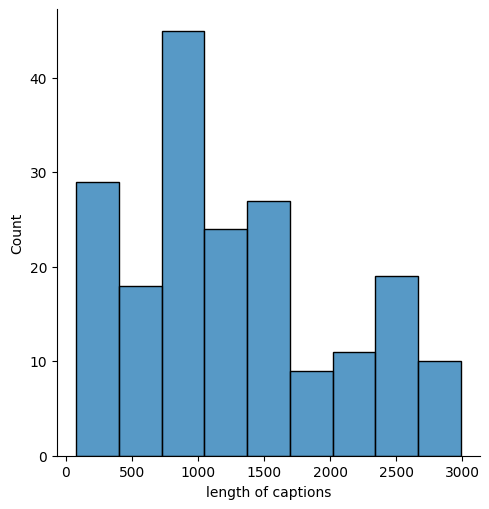

In [13]:
#Посмотрим на длину последоватеьностей
fig = sns.displot([len(sent) for sent in descriptions_train["descriptions_preproc"]])
plt.xlabel("length of captions")
plt.savefig(f"captions_length.png", bbox_inches='tight', format="png")
plt.show()

In [14]:
class WbDataset(Dataset):
    def __init__(self,
                 img_paths: list[Path],
                 img_embeds: torch.Tensor,
                 descriptions: list[str],
                 tokenizer: Tokenizer,
                 max_length: int = 5000,
                ):

        self.img_paths = img_paths
        self.img_embeds = img_embeds
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.descriptions = descriptions
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]

        ids = self.tokenizer.encode(self.descriptions[index]).ids[:self.max_length]
        out = {"embed": self.img_embeds[index], "description": ids, "path": str(img_path)}
 
        return out


    def __len__(self):
        return len(self.img_embeds)

In [15]:
train_dataset = WbDataset(img_paths=train_paths,
                          img_embeds=embeddings_train,
                          descriptions=descriptions_train["descriptions_preproc"],
                          tokenizer=tokenizer,
                         )

test_dataset = WbDataset(img_paths=test_paths,
                         img_embeds=embeddings_test,
                         descriptions=descriptions_test["descriptions_preproc"],
                         tokenizer=tokenizer,
                         )

if TRAIN_VAL:
    val_dataset = WbDataset(img_paths=val_paths,
                            img_embeds=embeddings_val,
                            descriptions=descriptions_val["descriptions_preproc"],
                            tokenizer=tokenizer,
                            )    

In [16]:
lengths = [len(train_dataset[i]["description"]) for i in range(len(train_dataset))]
np.max(lengths)

498

In [17]:
lengths = [len(test_dataset[i]["description"]) for i in range(len(test_dataset))]
print(np.max(lengths))
lengths = [len(val_dataset[i]["description"]) for i in range(len(val_dataset))]
print(np.max(lengths))

563
538


In [18]:
item = train_dataset[0]

print(item.keys())
print(item["embed"].shape)
print(len(item["description"]))
print(len(tokenizer.decode(item["description"]).split()))

dict_keys(['embed', 'description', 'path'])
torch.Size([1024])
241
239


In [19]:
class Collator:
    def __init__(self, transform=None, mixes=None) -> None:
        self.transform = transform
        self.mixes = mixes

    def __call__(self, batch):
        tensor_dict = defaultdict(list)
        for sample in batch:
            for key, value in sample.items():
                tensor_dict[key].append(value)

        data = torch.stack(tensor_dict["embed"])
        
        # Pad values
        out = {
            "embed": data,
            "description": pad_sequence([torch.tensor(t) for t in tensor_dict["description"]], batch_first=True),
            "path": tensor_dict["path"],
        }

        return out

# батч

In [20]:
# train_dataset = torch.utils.data.Subset(train_dataset, [i for i in range(8)])
# test_dataset = torch.utils.data.Subset(test_dataset, [i for i in range(8)])
BATCH_SIZE = 4

train_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=Collator(),
                                               pin_memory=True,
                                               generator=torch.Generator().manual_seed(SEED),
                                               worker_init_fn=seed_worker)
                                                                  )


val_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

if TRAIN_VAL:
    train_val_loader = accelerator.prepare_data_loader(DataLoader(val_dataset,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False,
                                                       collate_fn=Collator(),
                                                       pin_memory=True,
                                                       generator=torch.Generator().manual_seed(SEED),
                                                       worker_init_fn=seed_worker)
                                                                          )   

In [21]:
elem = next(iter(train_loader))
#elem['img'][0].shape

# visualise_1pic(elem[0][0])

In [22]:
elem["embed"].shape

torch.Size([4, 1024])

In [23]:
elem['description'].shape

torch.Size([4, 465])

In [24]:
elem['description'][0]

tensor([   1, 7738, 1460,  378,  477,   59,  312, 2643,   65, 5438,  100, 1213,
          11,  100, 1385, 2183,   11,  100, 1792,   13, 4322,  312,   12, 2389,
        8435, 4353,   65, 3237, 1818,   13,  732,  795,   74, 6418, 8593, 7373,
        7827, 5875,   59, 8356, 3747,   74, 8058,   13, 1364,  398, 7892, 7657,
        8270,  928, 6480,   11, 1908, 2786, 2516, 4179, 4143,   13,  378,  477,
        3710, 7282, 1184,   67, 3183,   65, 2355, 8409, 6733,  100, 2033, 8859,
        4034,   13, 1194,   12,  109, 8174,   11,  249, 8161,  477,  110,  194,
        5744, 8729,   65, 8116,   11, 1180,   91,  249,  300, 2642, 4669, 8720,
        7480,   99, 8101,   11,   65, 4700, 7272, 8075, 8348,   65, 8817,   13,
        5825,   59,  969, 7586,   13, 1393,  820,  100,  558,  245,   13, 1473,
          12,   22,  785,   13, 1000,  100, 7181, 7496, 2525,   13, 7555,   59,
        5406, 6447, 8645,   74,   13, 8274, 2447, 2578,   13, 8620,  157, 7525,
        2525,   13, 2103,  676, 4944,  1

___

Доделать по датасету:
 - добавить decode encode

Нерешенные вопросы:
 - подумать какой лучше брать токенайзер
 - как делать предикт:
   - categorical или argmax
   - критерии останова
   - как прогонять сразу батчом

In [25]:
class DecoderRNN(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        image_embed_dim,
        embed_dim : int = 256,
        hidden_dim : int = 256,
        lstm_layers : int = 1,
        dropout_prob: float = 0.1,
    ):
        super().__init__()
        
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim
        self.tokenizer = tokenizer
        
        self.image_embed_to_h0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        
        self.embed = torch.nn.Embedding(
            num_embeddings=tokenizer.get_vocab_size(),
            embedding_dim=embed_dim,
            padding_idx=tokenizer.get_vocab()["[PAD]"],
        )
#         self.lstm = torch.nn.LSTM(
#             input_size=embed_dim, 
#             hidden_size=hidden_dim,
#             num_layers=lstm_layers,
#             batch_first=True, 
#         )
        self.lstm = torch.nn.LSTMCell(
            input_size=embed_dim, 
            hidden_size=hidden_dim, 
        )
        
        self.linear = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=hidden_dim, out_features=tokenizer.get_vocab_size()),
        )

    def forward(self, image_embeds, captions):
        batch_size = image_embeds.shape[0]
        h0 = self.image_embed_to_h0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c0 = self.image_embed_to_c0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        print(h0.shape)
        return
        
        embeds = self.embed(captions)
        lengths = (captions != 0).sum(dim=-1).cpu()
        
#         print(h0.shape)
#         print(embeds.shape)
        packed = pack_padded_sequence(embeds, lengths=lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (h, c) = self.lstm(packed, (h0, c0))
        output, lens_unpacked = pad_packed_sequence(lstm_out, batch_first=True)
#         print(output.shape)
        logits = self.linear(output)
#         print(logits.shape)

        return logits
    
    
    @torch.no_grad()
    def caption_image(
        self,
        image_embeds : torch.Tensor,
        max_length : int = 300,
        greedy : bool = False,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)

        # init tokens with <bos>
        tokens = torch.full((batch_size, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        new_tokens = tokens
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < max_length:
            if ((tokens == self.tokenizer.get_vocab()["[EOS]"]).sum(1) > 0).all():   # тут надо проверить
                break  

            embeds = self.embed(new_tokens)
            output, (h, c) = self.lstm(embeds, (h, c))
#             print(output.shape)
            logits = self.linear(output)

            if greedy:
                new_tokens = logits.argmax(dim=-1)
            else:
                new_tokens = Categorical(logits=logits).sample()      #logits.argmax(dim=-1)
            tokens = torch.cat([tokens, new_tokens], dim=1)                              # концовка будет другая

        return tokens


#     @torch.no_grad()
#     def caption_image_beam_search(
#         self,
#         image_embeds : torch.Tensor,
#         beam_size : int,
#         max_length : int = 300,
#     ):
#         self.eval()

#         batch_size = image_embeds.shape[0]
#         if batch_size > 1:
#             raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        
#         h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
#                                                          self.lstm_layers,
#                                                          self.hidden_dim).transpose(0, 1)
#         c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
#                                                          self.lstm_layers,
#                                                          self.hidden_dim).transpose(0, 1)

#         k = beam_size
#         # init tokens with <bos>
#         # tokens = seqs, new_token = k_prev_word
#         k_prev_words = torch.full((k, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
#         seqs = k_prev_words
        
#         top_k_scores = torch.zeros(k, 1, device=image_embeds.device)
        
#         complete_seqs = list()
#         complete_seqs_scores = list()
        
#         h, c = h.expand(-1, k, self.hidden_dim), c.expand(-1, k, self.hidden_dim)
#         h, c = h.contiguous(), c.contiguous()
        
#         # 2 stopping conditions: reaching max len or getting <eos> token
#         step = 1        
#         while True:
# #             if ((tokens == self.tokenizer.get_vocab()["[EOS]"]).sum(1) > 0).all():   # тут надо проверить
# #                 break  

#             embeds = self.embed(k_prev_words)
#             output, (h, c) = self.lstm(embeds, (h, c))
# #             print(output.shape)
#             logits = self.linear(output)
#             print(logits.shape)
#             scores = F.log_softmax(logits[:, -1:, :], dim=-1)
#             print(scores.shape)
#             scores = scores.reshape(k, self.tokenizer.get_vocab_size())
            
#             print(top_k_scores.shape, scores.shape, h.shape)
#             scores = top_k_scores.expand_as(scores) + scores
            
#             if step == 1:
#                 top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
#                 print(top_k_scores.shape, top_k_words.shape)
#                 print(top_k_scores, top_k_words)
#             else:
#                 top_k_scores, top_k_words = scores.topk(k, -1, True, True)
#                 print(top_k_scores.shape, top_k_words.shape)
#                 print(top_k_scores, top_k_words)
            
#             print(seqs.shape)
#             print(seqs)
#             seqs = torch.cat([seqs, top_k_words.unsqueeze(1)], dim=-1)
#             print(seqs)
            
#             incomplete_inds = [ind for ind, next_word in enumerate(top_k_words) if
#                                next_word != self.tokenizer.get_vocab()["[EOS]"]]
#             complete_inds = list(set(range(len(top_k_words))) - set(incomplete_inds))

#             print(complete_inds, incomplete_inds)
#             k -= len(complete_inds)
#             if k == 0:
#                 break
            
#             seqs = seqs[incomplete_inds]
#             h = h[0][incomplete_inds].reshape(-1, k, self.hidden_dim)
#             c = c[0][incomplete_inds].reshape(-1, k, self.hidden_dim)
#             top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
#             k_prev_words = torch.cat([k_prev_words[incomplete_inds], top_k_words[incomplete_inds].unsqueeze(1)], dim=-1)
#             print(k_prev_words)
#             print("----------------------------------------------------------------")
# #             return

# #             new_tokens = Categorical(logits=logits).sample()      #logits.argmax(dim=-1)
# #             tokens = torch.cat([tokens, new_tokens], dim=1)                              # концовка будет другая

#             if step > max_length:
#                 break
#             step += 1

#         return

    @torch.no_grad()
    def caption_image_beam_search(
        self,
        image_embeds : torch.Tensor,
        beam_size : int,
        max_length : int = 300,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)

        k = beam_size
        # init tokens with <bos>
        # tokens = seqs, new_token = k_prev_word
        k_prev_words = torch.full((k, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        seqs = k_prev_words
        
        top_k_scores = torch.zeros(k, 1, device=image_embeds.device)
        
        complete_seqs = list()
        complete_seqs_scores = list()
        uncomplete_seqs = list()
        uncomplete_seqs_scores = list()
        
        h, c = h.expand(self.lstm_layers, k, self.hidden_dim), c.expand(self.lstm_layers, k, self.hidden_dim)
        h, c = h.contiguous(), c.contiguous()
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        step = 1        
        while True:
            embeds = self.embed(k_prev_words)
            output, (h, c) = self.lstm(embeds, (h, c))
#             print(output.shape)
            logits = self.linear(output)
#             print(logits.shape)
            scores = F.log_softmax(logits[:, -1:, :], dim=-1)
#             print(scores.shape)
            scores = scores.reshape(k, self.tokenizer.get_vocab_size())
            
#             print(top_k_scores.shape, scores.shape, h.shape)
            scores = top_k_scores.expand_as(scores) + scores
            
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
#                 print(top_k_scores.shape, top_k_words.shape)
#                 print(top_k_scores, top_k_words)
                seqs = torch.cat([seqs, top_k_words.unsqueeze(1)], dim=-1)
            else:
                # выбираем 9 наилучших (по 3 для каждого предсказания)
                top_kk_scores, top_kk_words = scores.topk(k, -1, True, True)
#                 print(top_kk_scores.shape, top_kk_words.shape)
#                 print(top_kk_scores, top_kk_words)
                
                # выбираем из 9 наилучших 3 наилучшие
                top_k_scores, top_k_idx_flat = top_kk_scores.view(-1).topk(k, 0, True, True)
                top_k_idx_col = top_k_idx_flat // k
                top_k_idx_row = top_k_idx_flat % k
                top_k_idx = torch.cat([top_k_idx_col.unsqueeze(1), top_k_idx_row.unsqueeze(1)], dim=-1) 
#                 for i in range(top_k_scores.shape[0]):
#                     if i == 0:
#                         top_k_idx = torch.cat([(top_kk_scores == top_k_scores[i]).nonzero()])
#                     else:
#                         top_k_idx = torch.cat([top_k_idx, (top_kk_scores == top_k_scores[i]).nonzero()])
                
                # переформировываем соответствующе 3м наилучшим seqs 
                for i in range(top_k_idx.shape[0]):
                    num_str = top_k_idx[i][0]
                    top_k_word = top_kk_words[num_str][top_k_idx[i][1]].unsqueeze(0) 
                    seq = torch.cat([seqs[num_str], top_k_word], dim=0).unsqueeze(0)
                    if i == 0:        
                        seqs_new = torch.cat([seq], dim=0)
                        h_new = torch.cat([h[:, [num_str], :]], dim=1)
                        c_new = torch.cat([c[:, [num_str], :]], dim=1)
                        num_strs = torch.cat([num_str.unsqueeze(0)], dim=0)
                        top_k_words = torch.cat([top_k_word], dim=0)
                    else:
                        seqs_new = torch.cat([seqs_new, seq], dim=0)
                        
                        h_new = torch.cat([h_new, h[:, [num_str], :]], dim=1)
                        c_new = torch.cat([c_new, c[:, [num_str], :]], dim=1)
                        num_strs = torch.cat([num_strs, num_str.unsqueeze(0)], dim=0)
                        top_k_words = torch.cat([top_k_words, top_k_word], dim=0)
                seqs = copy.deepcopy(seqs_new)
                h = copy.deepcopy(h_new)
                c = copy.deepcopy(c_new)
            
#             print(seqs.shape)
#             print(seqs)
            
            incomplete_inds = [ind for ind, next_word in enumerate(top_k_words) if
                               next_word != self.tokenizer.get_vocab()["[EOS]"]]
            complete_inds = list(set(range(len(top_k_words))) - set(incomplete_inds))

#             print(complete_inds, incomplete_inds)
            if len(complete_inds) > 0:
                complete_seqs.append(seqs[complete_inds])
                complete_seqs_scores.append(top_k_scores[complete_inds])
                
            k -= len(complete_inds)            
            if k == 0:
                break
            
            seqs = seqs[incomplete_inds]
            h = h[:, incomplete_inds, :].reshape(self.lstm_layers, k, self.hidden_dim)
            c = c[:, incomplete_inds, :].reshape(self.lstm_layers, k, self.hidden_dim)
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = seqs[:, -1:]                                  # seqs[:, -k:] сколько последних слов подавать в модель
#             print(k_prev_words)
#             print("----------------------------------------------------------------")

            if step > max_length:
#                 print(seqs)
#                 print(incomplete_inds)
#                 print(top_k_scores)
                uncomplete_seqs.append(seqs[incomplete_inds])
                uncomplete_seqs_scores.append(top_k_scores[incomplete_inds])
                break
            step += 1

        return complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores

In [25]:
class DecoderRNN(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        image_embed_dim,
        embed_dim : int = 256,
        hidden_dim : int = 256,
        lstm_layers : int = 1,
        dropout_prob: float = 0.1,
        max_lstm_steps: int = 1084,
    ):
        super().__init__()
        
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim
        self.tokenizer = tokenizer
        
        self.image_embed_to_h0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        
        self.embed = torch.nn.Embedding(
            num_embeddings=tokenizer.get_vocab_size(),
            embedding_dim=embed_dim,
            padding_idx=tokenizer.get_vocab()["[PAD]"],
        )
        self.lstm_cell = torch.nn.LSTMCell(
            input_size=embed_dim, 
            hidden_size=hidden_dim, 
        )
                
        init_weights_h = torch.nn.init.kaiming_uniform_(torch.empty(max_lstm_steps, 1), a=math.sqrt(5))
        init_weights_c = torch.nn.init.kaiming_uniform_(torch.empty(max_lstm_steps, 1), a=math.sqrt(5))
        self.weighing_lstm_h = torch.nn.Parameter(data=torch.Tensor(init_weights_h))
        self.weighing_lstm_c = torch.nn.Parameter(data=torch.Tensor(init_weights_c))

        
        self.linear = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=hidden_dim, out_features=tokenizer.get_vocab_size()),
        )

    def forward(self, image_embeds, captions):
        batch_size = image_embeds.shape[0]
        
        lengths = (captions != 0).sum(dim=-1)
        lengths, sort_ind = lengths.sort(dim=0, descending=True)
        original_order = torch.argsort(sort_ind)
        image_embeds = image_embeds[sort_ind]
        captions = captions[sort_ind]
        max_lengths = lengths[0]
        
        embeds = self.embed(captions)
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size, self.hidden_dim)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size, self.hidden_dim)
    
        logits = torch.zeros(batch_size, max_lengths, self.tokenizer.get_vocab_size(), device=image_embeds.device)
        
        for t in range(max_lengths):
            batch_size_t = sum([l > t for l in lengths])

#             print(embeds.shape)
#             print(embeds[:batch_size_t, t, :].shape, h[:batch_size_t].shape)
            h, c = self.lstm_cell(embeds[:batch_size_t, t, :], (h[:batch_size_t], c[:batch_size_t]))
            output = self.linear(h)
            logits[:batch_size_t, t, :] = output
#             print("a1", h.shape)
            
            if t == 0:
                h_ts = torch.cat([h], dim=-1).reshape((batch_size, t+1, self.hidden_dim))
                c_ts = torch.cat([c], dim=-1).reshape((batch_size, t+1, self.hidden_dim))
#                 print(h_ts.shape)
            else:
                if batch_size_t < batch_size:
                    hc_fill = torch.zeros(batch_size - batch_size_t, self.hidden_dim, device=image_embeds.device)
#                     print(h_fill.shape)
                    h = torch.cat([h, hc_fill], dim=0)
                    c = torch.cat([c, hc_fill], dim=0)
#                     print("a2", h.shape)
                h_ts = torch.cat([h_ts, h.unsqueeze(1)], dim=-2)
                c_ts = torch.cat([c_ts, c.unsqueeze(1)], dim=-2)
#                 print(h_ts.shape)
            
                h = (h_ts * self.weighing_lstm_h[:t+1]).sum(dim=-2)
                c = (c_ts * self.weighing_lstm_c[:t+1]).sum(dim=-2)

        return logits[original_order]
    

    @torch.no_grad()
    def caption_image(
        self,
        image_embeds : torch.Tensor,
        max_length : int = 300,
        greedy : bool = False,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size, self.hidden_dim)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size, self.hidden_dim)

        # init tokens with <bos>
        tokens = torch.full((batch_size, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        new_tokens = tokens
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        t = 0
        while tokens.shape[1] < max_length:
            if ((tokens == self.tokenizer.get_vocab()["[EOS]"]).sum(1) > 0).all():
                break  

            embeds = self.embed(new_tokens)
            h, c = self.lstm_cell(embeds.squeeze(0), (h, c))
            logits = self.linear(h).unsqueeze(1)

            if greedy:
                new_tokens = logits.argmax(dim=-1)
            else:
                new_tokens = Categorical(logits=logits).sample()
#             print(tokens.shape, new_tokens.shape)
            tokens = torch.cat([tokens, new_tokens], dim=1) 

            
            if t == 0:
                h_ts = torch.cat([h], dim=-1).reshape((batch_size, t+1, self.hidden_dim))
                c_ts = torch.cat([c], dim=-1).reshape((batch_size, t+1, self.hidden_dim))
            else:
                h_ts = torch.cat([h_ts, h.unsqueeze(1)], dim=-2)
                c_ts = torch.cat([c_ts, c.unsqueeze(1)], dim=-2)
            
                h = (h_ts * self.weighing_lstm_h[:t+1]).sum(dim=-2)
                c = (c_ts * self.weighing_lstm_c[:t+1]).sum(dim=-2)
            t += 1
           
        return tokens
   

    @torch.no_grad()
    def caption_image_beam_search(
        self,
        image_embeds : torch.Tensor,
        beam_size : int,
        max_length : int = 300,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size, self.hidden_dim)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size, self.hidden_dim)

        k = beam_size
        # init tokens with <bos>
        # tokens = seqs, new_token = k_prev_word
        k_prev_words = torch.full((k, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        seqs = k_prev_words
        
        top_k_scores = torch.zeros(k, 1, device=image_embeds.device)
        
        complete_seqs = list()
        complete_seqs_scores = list()
        uncomplete_seqs = list()
        uncomplete_seqs_scores = list()
        
#         print(h.shape)
        h, c = h.expand(batch_size, k, self.hidden_dim), c.expand(batch_size, k, self.hidden_dim)
        h, c = h.contiguous(), c.contiguous()
        print("init", c.shape, h.shape)
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        step = 1        
        while True:
            embeds = self.embed(k_prev_words)
            h, c = self.lstm_cell(embeds.squeeze(1), (h.squeeze(0), c.squeeze(0)))
            logits = self.linear(h.unsqueeze(1))
            h, c = h.unsqueeze(0), c.unsqueeze(0)
            print("a1", logits.shape, h.shape, c.shape)
            scores = F.log_softmax(logits[:, -1:, :], dim=-1)
            scores = scores.reshape(k, self.tokenizer.get_vocab_size())
            
            scores = top_k_scores.expand_as(scores) + scores
            
            # добавляем перевзвешивание
            if step == 1:
                h_ts = torch.cat([h], dim=-1).reshape((batch_size, k, step, self.hidden_dim))
                c_ts = torch.cat([c], dim=-1).reshape((batch_size, k, step, self.hidden_dim))
            else:
                print(h.shape, c.shape)
                h_ts = torch.cat([h_ts, h.unsqueeze(2)], dim=-2)
                c_ts = torch.cat([c_ts, c.unsqueeze(2)], dim=-2)  
                h = (h_ts * self.weighing_lstm_h[:step]).sum(dim=-2)
                c = (c_ts * self.weighing_lstm_c[:step]).sum(dim=-2)
                print(h.shape, h_ts.shape)
        
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
                seqs = torch.cat([seqs, top_k_words.unsqueeze(1)], dim=-1)
            else:
                # выбираем 9 наилучших (по 3 для каждого предсказания)
                top_kk_scores, top_kk_words = scores.topk(k, -1, True, True)
                
                # выбираем из 9 наилучших 3 наилучшие
                top_k_scores, top_k_idx_flat = top_kk_scores.view(-1).topk(k, 0, True, True)
                top_k_idx_col = top_k_idx_flat // k
                top_k_idx_row = top_k_idx_flat % k
                top_k_idx = torch.cat([top_k_idx_col.unsqueeze(1), top_k_idx_row.unsqueeze(1)], dim=-1) 
                
                # переформировываем соответствующе 3м наилучшим seqs 
                for i in range(top_k_idx.shape[0]):
                    num_str = top_k_idx[i][0]
                    top_k_word = top_kk_words[num_str][top_k_idx[i][1]].unsqueeze(0) 
                    seq = torch.cat([seqs[num_str], top_k_word], dim=0).unsqueeze(0)
                    if i == 0:        
                        seqs_new = torch.cat([seq], dim=0)
                        h_new = torch.cat([h[:, [num_str], :]], dim=1)
                        c_new = torch.cat([c[:, [num_str], :]], dim=1)
                        h_ts_new = torch.cat([h_ts[:, [num_str], :, :]], dim=-1)
                        c_ts_new = torch.cat([c_ts[:, [num_str], :, :]], dim=-1)
                        num_strs = torch.cat([num_str.unsqueeze(0)], dim=0)
                        top_k_words = torch.cat([top_k_word], dim=0)
                    else:
                        seqs_new = torch.cat([seqs_new, seq], dim=0)
                        print("a3", h.shape, h[:, [num_str], :].shape, h_ts.shape)
                        h_new = torch.cat([h_new, h[:, [num_str], :]], dim=1)
                        c_new = torch.cat([c_new, c[:, [num_str], :]], dim=1)
                        h_ts_new = torch.cat([h_ts_new, h_ts[:, [num_str], :, :]], dim=-3)
                        c_ts_new = torch.cat([c_ts_new, c_ts[:, [num_str], :, :]], dim=-3)
                        print("a4", h_ts_new.shape)                     
                        num_strs = torch.cat([num_strs, num_str.unsqueeze(0)], dim=0)
                        top_k_words = torch.cat([top_k_words, top_k_word], dim=0)
                seqs = copy.deepcopy(seqs_new)
                h = copy.deepcopy(h_new)
                c = copy.deepcopy(c_new)
                h_ts = copy.deepcopy(h_ts_new)
                c_ts = copy.deepcopy(c_ts_new)
                print(h.shape)
            
#             print(seqs.shape)
#             print(seqs)
            
            incomplete_inds = [ind for ind, next_word in enumerate(top_k_words) if
                               next_word != self.tokenizer.get_vocab()["[EOS]"]]
            complete_inds = list(set(range(len(top_k_words))) - set(incomplete_inds))

            if len(complete_inds) > 0:
                complete_seqs.append(seqs[complete_inds])
                complete_seqs_scores.append(top_k_scores[complete_inds])
            
                print("complete_inds", complete_inds)
            k -= len(complete_inds)            
            if k == 0:
                break
            
            seqs = seqs[incomplete_inds]
            print(h.shape, c.shape)
            h = h[:, incomplete_inds, :].reshape(self.lstm_layers, k, self.hidden_dim)
            c = c[:, incomplete_inds, :].reshape(self.lstm_layers, k, self.hidden_dim)
            h_ts = h_ts[:, incomplete_inds, :, :]
            c_ts = c_ts[:, incomplete_inds, :, :]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = seqs[:, -1:]                                  # seqs[:, -k:] сколько последних слов подавать в модель
#             print(k_prev_words)
            print("----------------------------------------------------------------")

            if step > max_length:
                uncomplete_seqs.append(seqs[incomplete_inds])
                uncomplete_seqs_scores.append(top_k_scores[incomplete_inds])
                break
            step += 1

        return complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores

In [74]:
complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores = model.caption_image_beam_search(
                                                                      image_embeds=batch['embed'],
                                                                      beam_size=3,
                                                                      max_length=1083)

init torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 2, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 2, 128])
a4 torch.Size([1, 2, 2, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 2, 128])
a4 torch.Size([1, 3, 2, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 3, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torc

----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 19, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 19, 128])
a4 torch.Size([1, 2, 19, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 19, 128])
a4 torch.Size([1, 3, 19, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 20, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 20, 128])
a4 torch.Size([1, 2, 20, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 20, 128])
a4 torch.Size([1, 3, 20, 128])
torch.

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 36, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 36, 128])
a4 torch.Size([1, 2, 36, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 36, 128])
a4 torch.Size([1, 3, 36, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 37, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 37, 128])
a4 torch.Size([1, 2, 37, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3,

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 52, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 52, 128])
a4 torch.Size([1, 2, 52, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 52, 128])
a4 torch.Size([1, 3, 52, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 53, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 53, 128])
a4 torch.Size([1, 2, 53, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 53, 128])
a4 torch.Size([1, 3, 53, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.S

a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 69, 128])
a4 torch.Size([1, 2, 69, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 69, 128])
a4 torch.Size([1, 3, 69, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 70, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 70, 128])
a4 torch.Size([1, 2, 70, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 70, 128])
a4 torch.Size([1, 3, 70, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 89, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 89, 128])
a4 torch.Size([1, 2, 89, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 89, 128])
a4 torch.Size([1, 3, 89, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 90, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 90, 128])
a4 torch.Size([1, 2, 90, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3,

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 105, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 105, 128])
a4 torch.Size([1, 2, 105, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 105, 128])
a4 torch.Size([1, 3, 105, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 106, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 106, 128])
a4 torch.Size([1, 2, 106, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 125, 128])
a4 torch.Size([1, 2, 125, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 125, 128])
a4 torch.Size([1, 3, 125, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 126, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 126, 128])
a4 torch.Size([1, 2, 126, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 126, 128])
a4 torch.Size([1, 3, 126, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) t

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 141, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 141, 128])
a4 torch.Size([1, 2, 141, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 141, 128])
a4 torch.Size([1, 3, 141, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 142, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 142, 128])
a4 torch.Size([1, 2, 142, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 156, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 156, 128])
a4 torch.Size([1, 2, 156, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 156, 128])
a4 torch.Size([1, 3, 156, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 157, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 157, 128])
a4 torch.Size([1, 2, 157, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 157, 128])
a4 torch.Size([1, 3, 157, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------


a4 torch.Size([1, 2, 176, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 176, 128])
a4 torch.Size([1, 3, 176, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 177, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 177, 128])
a4 torch.Size([1, 2, 177, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 177, 128])
a4 torch.Size([1, 3, 177, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 178, 128])
a3 t

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 195, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 195, 128])
a4 torch.Size([1, 2, 195, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 195, 128])
a4 torch.Size([1, 3, 195, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 196, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 196, 128])
a4 torch.Size([1, 2, 196, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 196, 128])
a4 torch.Size([1, 3, 196, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------


torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 211, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 211, 128])
a4 torch.Size([1, 2, 211, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 211, 128])
a4 torch.Size([1, 3, 211, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 212, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 212, 128])
a4 torch.Size([1, 2, 212, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 231, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 231, 128])
a4 torch.Size([1, 2, 231, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 231, 128])
a4 torch.Size([1, 3, 231, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 232, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 232, 128])
a4 torch.Size([1, 2, 232, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 232, 128])
a4 torch.Size([1, 3, 232, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------


torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 251, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 251, 128])
a4 torch.Size([1, 2, 251, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 251, 128])
a4 torch.Size([1, 3, 251, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 252, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 252, 128])
a4 torch.Size([1, 2, 252, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 271, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 271, 128])
a4 torch.Size([1, 2, 271, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 271, 128])
a4 torch.Size([1, 3, 271, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 272, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 272, 128])
a4 torch.Size([1, 2, 272, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 272, 128])
a4 torch.Size([1, 3, 272, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------


a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 291, 128])
a4 torch.Size([1, 2, 291, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 291, 128])
a4 torch.Size([1, 3, 291, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 292, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 292, 128])
a4 torch.Size([1, 2, 292, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 292, 128])
a4 torch.Size([1, 3, 292, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) t

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 311, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 311, 128])
a4 torch.Size([1, 2, 311, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 311, 128])
a4 torch.Size([1, 3, 311, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 312, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 312, 128])
a4 torch.Size([1, 2, 312, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 331, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 331, 128])
a4 torch.Size([1, 2, 331, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 331, 128])
a4 torch.Size([1, 3, 331, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 332, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 332, 128])
a4 torch.Size([1, 2, 332, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 351, 128])
a4 torch.Size([1, 2, 351, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 351, 128])
a4 torch.Size([1, 3, 351, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 352, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 352, 128])
a4 torch.Size([1, 2, 352, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 352, 128])
a4 torch.Size([1, 3, 352, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) t

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 371, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 371, 128])
a4 torch.Size([1, 2, 371, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 371, 128])
a4 torch.Size([1, 3, 371, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 372, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 372, 128])
a4 torch.Size([1, 2, 372, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 391, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 391, 128])
a4 torch.Size([1, 2, 391, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 391, 128])
a4 torch.Size([1, 3, 391, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 392, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 392, 128])
a4 torch.Size([1, 2, 392, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 411, 128])
a4 torch.Size([1, 2, 411, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 411, 128])
a4 torch.Size([1, 3, 411, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 412, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 412, 128])
a4 torch.Size([1, 2, 412, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 412, 128])
a4 torch.Size([1, 3, 412, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) t

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 431, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 431, 128])
a4 torch.Size([1, 2, 431, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 431, 128])
a4 torch.Size([1, 3, 431, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 432, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 432, 128])
a4 torch.Size([1, 2, 432, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 451, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 451, 128])
a4 torch.Size([1, 2, 451, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 451, 128])
a4 torch.Size([1, 3, 451, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 452, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 452, 128])
a4 torch.Size([1, 2, 452, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 471, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 471, 128])
a4 torch.Size([1, 2, 471, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 471, 128])
a4 torch.Size([1, 3, 471, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 472, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 472, 128])
a4 torch.Size([1, 2, 472, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 491, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 491, 128])
a4 torch.Size([1, 2, 491, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 491, 128])
a4 torch.Size([1, 3, 491, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 492, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 492, 128])
a4 torch.Size([1, 2, 492, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 511, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 511, 128])
a4 torch.Size([1, 2, 511, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 511, 128])
a4 torch.Size([1, 3, 511, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 512, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 512, 128])
a4 torch.Size([1, 2, 512, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 531, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 531, 128])
a4 torch.Size([1, 2, 531, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 531, 128])
a4 torch.Size([1, 3, 531, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 532, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 532, 128])
a4 torch.Size([1, 2, 532, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 532, 128])
a4 torch.Size([1, 3, 532, 12

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 551, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 551, 128])
a4 torch.Size([1, 2, 551, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 551, 128])
a4 torch.Size([1, 3, 551, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 552, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 552, 128])
a4 torch.Size([1, 2, 552, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 571, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 571, 128])
a4 torch.Size([1, 2, 571, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 571, 128])
a4 torch.Size([1, 3, 571, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 572, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 572, 128])
a4 torch.Size([1, 2, 572, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 591, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 591, 128])
a4 torch.Size([1, 2, 591, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 591, 128])
a4 torch.Size([1, 3, 591, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 592, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 592, 128])
a4 torch.Size([1, 2, 592, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 611, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 611, 128])
a4 torch.Size([1, 2, 611, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 611, 128])
a4 torch.Size([1, 3, 611, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 612, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 612, 128])
a4 torch.Size([1, 2, 612, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 630, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 630, 128])
a4 torch.Size([1, 2, 630, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 630, 128])
a4 torch.Size([1, 3, 630, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 631, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 631, 128])
a4 torch.Size([1, 2, 631, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 650, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 650, 128])
a4 torch.Size([1, 2, 650, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 650, 128])
a4 torch.Size([1, 3, 650, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 651, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 651, 128])
a4 torch.Size([1, 2, 651, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 669, 128])
a4 torch.Size([1, 3, 669, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 670, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 670, 128])
a4 torch.Size([1, 2, 670, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 670, 128])
a4 torch.Size([1, 3, 670, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 671, 128])
a3 torch.Size([1, 3, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 689, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 689, 128])
a4 torch.Size([1, 2, 689, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 689, 128])
a4 torch.Size([1, 3, 689, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 690, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 690, 128])
a4 torch.Size([1, 2, 690, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 708, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 708, 128])
a4 torch.Size([1, 2, 708, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 708, 128])
a4 torch.Size([1, 3, 708, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 709, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 709, 128])
a4 torch.Size([1, 2, 709, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 709, 128])
a4 torch.Size([1, 3, 709, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------


torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 727, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 727, 128])
a4 torch.Size([1, 2, 727, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 727, 128])
a4 torch.Size([1, 3, 727, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 728, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 728, 128])
a4 torch.Size([1, 2, 728, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 747, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 747, 128])
a4 torch.Size([1, 2, 747, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 747, 128])
a4 torch.Size([1, 3, 747, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 748, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 748, 128])
a4 torch.Size([1, 2, 748, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 767, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 767, 128])
a4 torch.Size([1, 2, 767, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 767, 128])
a4 torch.Size([1, 3, 767, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 768, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 768, 128])
a4 torch.Size([1, 2, 768, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 787, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 787, 128])
a4 torch.Size([1, 2, 787, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 787, 128])
a4 torch.Size([1, 3, 787, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 788, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 788, 128])
a4 torch.Size([1, 2, 788, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 807, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 807, 128])
a4 torch.Size([1, 2, 807, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 807, 128])
a4 torch.Size([1, 3, 807, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 808, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 808, 128])
a4 torch.Size([1, 2, 808, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 827, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 827, 128])
a4 torch.Size([1, 2, 827, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 827, 128])
a4 torch.Size([1, 3, 827, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 828, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 828, 128])
a4 torch.Size([1, 2, 828, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 847, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 847, 128])
a4 torch.Size([1, 2, 847, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 847, 128])
a4 torch.Size([1, 3, 847, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 848, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 848, 128])
a4 torch.Size([1, 2, 848, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 867, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 867, 128])
a4 torch.Size([1, 2, 867, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 867, 128])
a4 torch.Size([1, 3, 867, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 868, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 868, 128])
a4 torch.Size([1, 2, 868, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

a4 torch.Size([1, 2, 886, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 886, 128])
a4 torch.Size([1, 3, 886, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 887, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 887, 128])
a4 torch.Size([1, 2, 887, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 887, 128])
a4 torch.Size([1, 3, 887, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 888, 128])
a3 t

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 905, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 905, 128])
a4 torch.Size([1, 2, 905, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 905, 128])
a4 torch.Size([1, 3, 905, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 906, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 906, 128])
a4 torch.Size([1, 2, 906, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 923, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 923, 128])
a4 torch.Size([1, 2, 923, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 923, 128])
a4 torch.Size([1, 3, 923, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 924, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 924, 128])
a4 torch.Size([1, 2, 924, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 924, 128])
a4 torch.Size([1, 3, 924, 12

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 940, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 940, 128])
a4 torch.Size([1, 2, 940, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 940, 128])
a4 torch.Size([1, 3, 940, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 941, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 941, 128])
a4 torch.Size([1, 2, 941, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 959, 128])
a4 torch.Size([1, 2, 959, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 959, 128])
a4 torch.Size([1, 3, 959, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 960, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 960, 128])
a4 torch.Size([1, 2, 960, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 960, 128])
a4 torch.Size([1, 3, 960, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) t

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 977, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 977, 128])
a4 torch.Size([1, 2, 977, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 977, 128])
a4 torch.Size([1, 3, 977, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 978, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 978, 128])
a4 torch.Size([1, 2, 978, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 995, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 995, 128])
a4 torch.Size([1, 2, 995, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 995, 128])
a4 torch.Size([1, 3, 995, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 996, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 996, 128])
a4 torch.Size([1, 2, 996, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 1013, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1013, 128])
a4 torch.Size([1, 2, 1013, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1013, 128])
a4 torch.Size([1, 3, 1013, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 1014, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1014, 128])
a4 torch.Size([1, 2, 1014, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) t

----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 1030, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1030, 128])
a4 torch.Size([1, 2, 1030, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1030, 128])
a4 torch.Size([1, 3, 1030, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 1031, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1031, 128])
a4 torch.Size([1, 2, 1031, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1031, 128])
a4 torch.Size([1, 3

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 1047, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1047, 128])
a4 torch.Size([1, 2, 1047, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1047, 128])
a4 torch.Size([1, 3, 1047, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 1048, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1048, 128])
a4 torch.Size([1, 2, 1048, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1048, 128])
a4 torch.Size([1, 3, 1048, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
-------------------------------------------------------

torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 1065, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1065, 128])
a4 torch.Size([1, 2, 1065, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1065, 128])
a4 torch.Size([1, 3, 1065, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 1066, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1066, 128])
a4 torch.Size([1, 2, 1066, 128])
a3 torch.Size([1, 3, 128]) t

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 1082, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1082, 128])
a4 torch.Size([1, 2, 1082, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1082, 128])
a4 torch.Size([1, 3, 1082, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 1083, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 1083, 128])
a4 torch.Size([1, 2, 1083, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) t

In [75]:
complete_seqs

[]

In [65]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=1,
    hidden_dim=128,
)

NUM_EPOCHS = 20
# optimizer = torch.optim.AdamW([{"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},],)
# criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
model.to(device)
# model, optimizer = accelerator.prepare(model, optimizer)

DecoderRNN(
  (image_embed_to_h0): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (image_embed_to_c0): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (embed): Embedding(8922, 256, padding_idx=0)
  (lstm_cell): LSTMCell(256, 128)
  (linear): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=8922, bias=True)
  )
)

In [28]:
test_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

for batch in test_loader:
    break

In [68]:
test_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [69]:
for batch in test_loader:
    break

In [61]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=1,
    hidden_dim=128,
)

NUM_EPOCHS = 20
optimizer = torch.optim.AdamW([{"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},],)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
model, optimizer = accelerator.prepare(model, optimizer)

trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )


train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True,
            check_train_val_loader=TRAIN_VAL, train_val_loader=train_val_loader,
            calculate_metrics=False, metrics_freq=100,
            saving_model=False, save_path_model=Path.cwd() / "rnn_test2")

Training 1/20:   0%|          | 0/48 [00:00<?, ?it/s]

torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) torch.Size([4, 128])
torch.Size([4, 410, 256])
torch.Size([4, 256]) t

torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 410, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.

torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.Size([4, 410, 256])
torch.Size([1, 256]) torch.Size([1, 128])
torch.

torch.Size([4, 416, 256])
torch.Size([3, 256]) torch.Size([3, 128])
torch.Size([4, 416, 256])
torch.Size([3, 256]) torch.Size([3, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) torch.Size([2, 128])
torch.Size([4, 416, 256])
torch.Size([2, 256]) t

KeyboardInterrupt: 

In [71]:
a1 = torch.Tensor(torch.arange(12)).reshape((3,4))
a1

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [72]:
a1[0, :]

tensor([0, 1, 2, 3])

In [46]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=1,
    hidden_dim=128,
)

model.load_state_dict(torch.load(Path.cwd() / "rnn_test" / "pytorch_model.bin"))
model = model.to(device)

RuntimeError: Error(s) in loading state_dict for DecoderRNN:
	Missing key(s) in state_dict: "weighing_lstm_h", "weighing_lstm_c". 
	Unexpected key(s) in state_dict: "weighing_lstm". 

In [44]:
# accelerator.save_state(output_dir=Path.cwd() / "rnn_test")

WindowsPath('C:/Users/sofi/jupyter projects/МОВС/HSE_MLDS_project_year2/rnn_test')

In [30]:
model.load_state_dict(torch.load(Path.cwd() / "rnn_test2" / "pytorch_model.bin"))

<All keys matched successfully>

In [26]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrics, test_metrics, val_losses=None, val_metrics=None):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(26, 13))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    if val_losses is not None:
        axs[0][0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0][0].set_ylabel('loss')

    if val_metrics is not None:
        for (ax1, ax2), train_m_name, test_m_name, val_m_name in zip(((0, 1), (1, 0), (1, 1)), train_metrics, test_metrics, val_metrics):
            train_m, test_m, val_m = train_metrics[train_m_name], test_metrics[test_m_name], val_metrics[val_m_name]
            axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
            axs[ax1][ax2].plot(range(1, len(test_m) + 1), test_m, label='test')
            axs[ax1][ax2].plot(range(1, len(val_m) + 1), val_m, label='val')
            axs[ax1][ax2].set_ylabel(train_m_name)    
    else:
        for (ax1, ax2), train_m_name, test_m_name in zip(((0, 1), (1, 0), (1, 1)), train_metrics, test_metrics):
            train_m, test_m = train_metrics[train_m_name], test_metrics[test_m_name]
            axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
            axs[ax1][ax2].plot(range(1, len(test_m) + 1), test_m, label='test')
            axs[ax1][ax2].set_ylabel(train_m_name)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlabel('epoch')
            ax2.legend()

    plt.show()

def calculate_bleu_wer(model, image_embeds, captions_true):
    bleu_scores = []
    wer_scores = []
    wer = WordErrorRate()
    
    for i in range(image_embeds.shape[0]):
        caption_pred = model.caption_image(image_embeds=image_embeds[i].view(1, -1))
        caption_true = model.tokenizer.decode(captions_true[i].detach().cpu().numpy())
        caption_pred = model.tokenizer.decode(caption_pred[0].detach().cpu().numpy())
    
        print(caption_pred)
        bleu_score = corpus_bleu([caption_pred], [caption_true]).score
        bleu_scores.append(bleu_score)
        
        wer_score = wer(caption_pred, caption_true)
        wer_scores.append(wer_score)
    
    bleu = np.mean(bleu_scores)
    wer = np.mean(wer_scores)
    
    return {"BLEU": bleu, "WER": wer}

In [27]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        criterion,
        accelerator,
        device,
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.accelerator = accelerator
        self.device = device

    @staticmethod
    def training_epoch(
        self,
        train_loader: DataLoader,
        epoch: int,
        tqdm_desc,
        train_metrics,
        metric_epoch : int,
        metrics_freq: int,
    ):
        num_batches = 0.0
        train_loss = 0.0
        metrics = defaultdict(float)
        self.model.train()
        
        for batch in tqdm(train_loader, desc=tqdm_desc):
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            with self.accelerator.accumulate(self.model):
                logits_captioning = self.model(img_embed, descriptions[:, :-1])
                loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])
                self.accelerator.backward(loss)
                self.optimizer.step()
                self.optimizer.zero_grad()

            train_loss += loss.item()
            
            if (metric_epoch) % metrics_freq == 0:
                metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
                for m_name, m in metrics_captioning.items():
                    metrics[m_name] += m
                self.model.train()
            
            num_batches += 1

        train_loss /= num_batches
        if (metric_epoch) % metrics_freq == 0:
            for m_name in metrics:
                metrics[m_name] /= num_batches
        else:
            for m_name in train_metrics:
                metrics[m_name] = train_metrics[m_name][-1]
            
        return train_loss, metrics

    @staticmethod
    @torch.no_grad()
    def validation_epoch(
        self,
        val_loader: DataLoader,
        epoch: int,
        tqdm_desc,
        val_metrics,
        metric_epoch : int,
        metrics_freq: int,
    ):
        num_batches = 0.0
        val_loss = 0.0
        metrics = defaultdict(float)
        self.model.eval()
        for batch in tqdm(val_loader, desc=tqdm_desc):
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            logits_captioning = self.model(img_embed, descriptions[:, :-1])
            loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])

            val_loss += loss.item()
            
            if (metric_epoch) % metrics_freq == 0:
                metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
                for m_name, m in metrics_captioning.items():
                    metrics[m_name] += m

            num_batches += 1

        val_loss /= num_batches
        if (metric_epoch) % metrics_freq == 0:
            for m_name in metrics:
                metrics[m_name] /= num_batches
        else:
            for m_name in val_metrics:
                metrics[m_name] = val_metrics[m_name][-1]

            
        return val_loss, metrics

    def train(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        num_epochs: int,
        plot: bool,
        check_train_val_loader: bool = False,
        train_val_loader: Optional[DataLoader] = None,
        calculate_metrics: bool = True,
        metrics_freq: int = 10,
        saving_checkpoint: bool = False,
        save_path_checkpoint: Optional[Path] = None,
        saving_model: bool = False,
        save_path_model: Optional[Path] = None,
    ):
        train_losses = []
        val_losses = []
        train_metrics, val_metrics = defaultdict(list), defaultdict(list)
        if check_train_val_loader:
            train_val_losses = []
            train_val_metrics = defaultdict(list)

        for epoch in range(1, num_epochs + 1):
            train_loss, train_metric = self.training_epoch(
                self,
                train_loader,
                epoch,
                tqdm_desc=f'Training {epoch}/{num_epochs}',
                train_metrics=train_metrics,
                metric_epoch=epoch-1 if calculate_metrics else epoch, 
                metrics_freq=metrics_freq,
            )
            val_loss, val_metric = self.validation_epoch(
                self,
                val_loader,
                epoch,
                tqdm_desc=f'Validating {epoch}/{num_epochs}',
                val_metrics=val_metrics,
                metric_epoch=epoch-1 if calculate_metrics else epoch,
                metrics_freq=metrics_freq,
            )
            
            if check_train_val_loader:
                train_val_loss, train_val_metric = self.validation_epoch(
                    self,
                    train_val_loader,
                    epoch,
                    tqdm_desc=f'Validating 2 {epoch}/{num_epochs}',
                    val_metrics=train_val_metrics,
                    metric_epoch=epoch-1 if calculate_metrics else epoch,
                    metrics_freq=metrics_freq,
                )                

            if self.scheduler is not None:
                self.scheduler.step()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            for m_name, m_value in train_metric.items():
                train_metrics[m_name].append(m_value)
            for m_name, m_value in val_metric.items():
                val_metrics[m_name].append(m_value)
            
            if check_train_val_loader:
                train_val_losses.append(train_val_loss)
                for m_name, m_value in train_val_metric.items():
                    train_val_metrics[m_name].append(m_value)
            
            if plot:
                if check_train_val_loader:
                    plot_losses(train_losses, val_losses, train_metrics, val_metrics, train_val_losses, train_val_metrics)
                else:
                    plot_losses(train_losses, val_losses, train_metrics, val_metrics)

            print(f"Epoch {epoch}")
            print("val metrics")
            print(f"loss {val_losses[-1]}")
            for elem in val_metrics.items():
                print(elem[0], elem[1][-1])
            print("\ntrain metrics")
            print(f"loss {train_losses[-1]}")
            for elem in train_metrics.items():
                print(elem[0], elem[1][-1])
            print('-'*50)

            if saving_checkpoint:
                accelerator.save_state(output_dir=save_path_checkpoint / f"checkpoint_afterepoch_{epoch}of{num_epochs}")

        if saving_model:
            shutil.rmtree(save_path_model, ignore_errors=True)
            accelerator.save_state(output_dir=save_path_model)

        return train_losses, val_losses, train_metrics, val_metrics

# прыг запуск training

In [28]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=1,
    hidden_dim=128,
)

sum(param.numel() for param in model.parameters())

3897170

In [29]:
NUM_EPOCHS = 100

# model = model.to(device)
optimizer = torch.optim.AdamW(
    [
        {"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
    ],
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
model, optimizer = accelerator.prepare(model, optimizer)

In [30]:
NUM_EPOCHS = 330

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


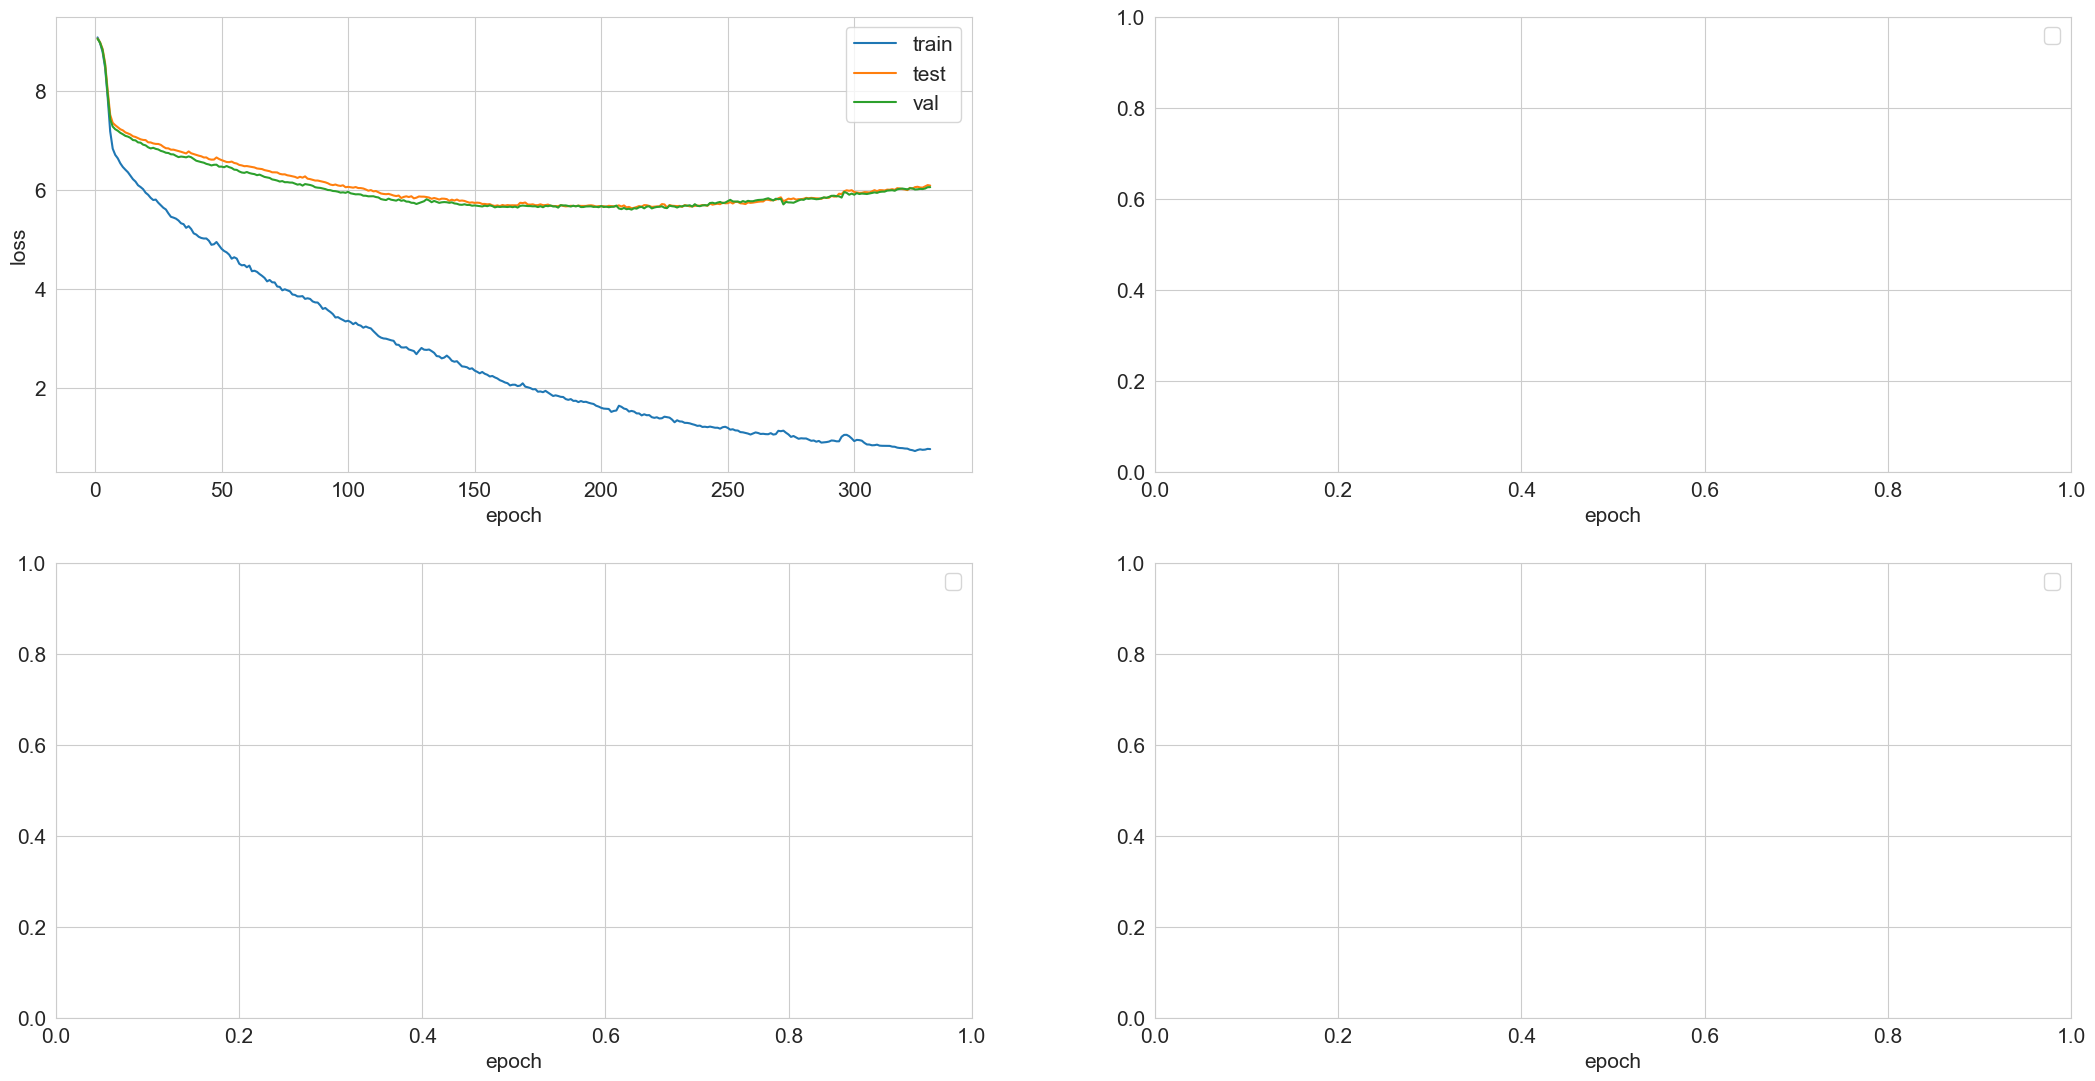

Epoch 330
val metrics
loss 6.0879065036773685

train metrics
loss 0.7551814708858728
--------------------------------------------------
6:14:30.524056


In [31]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True,
            check_train_val_loader=TRAIN_VAL, train_val_loader=train_val_loader,
            calculate_metrics=False, metrics_freq=1000,
            saving_model=True, save_path_model=Path.cwd() / "rnn_test2")
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


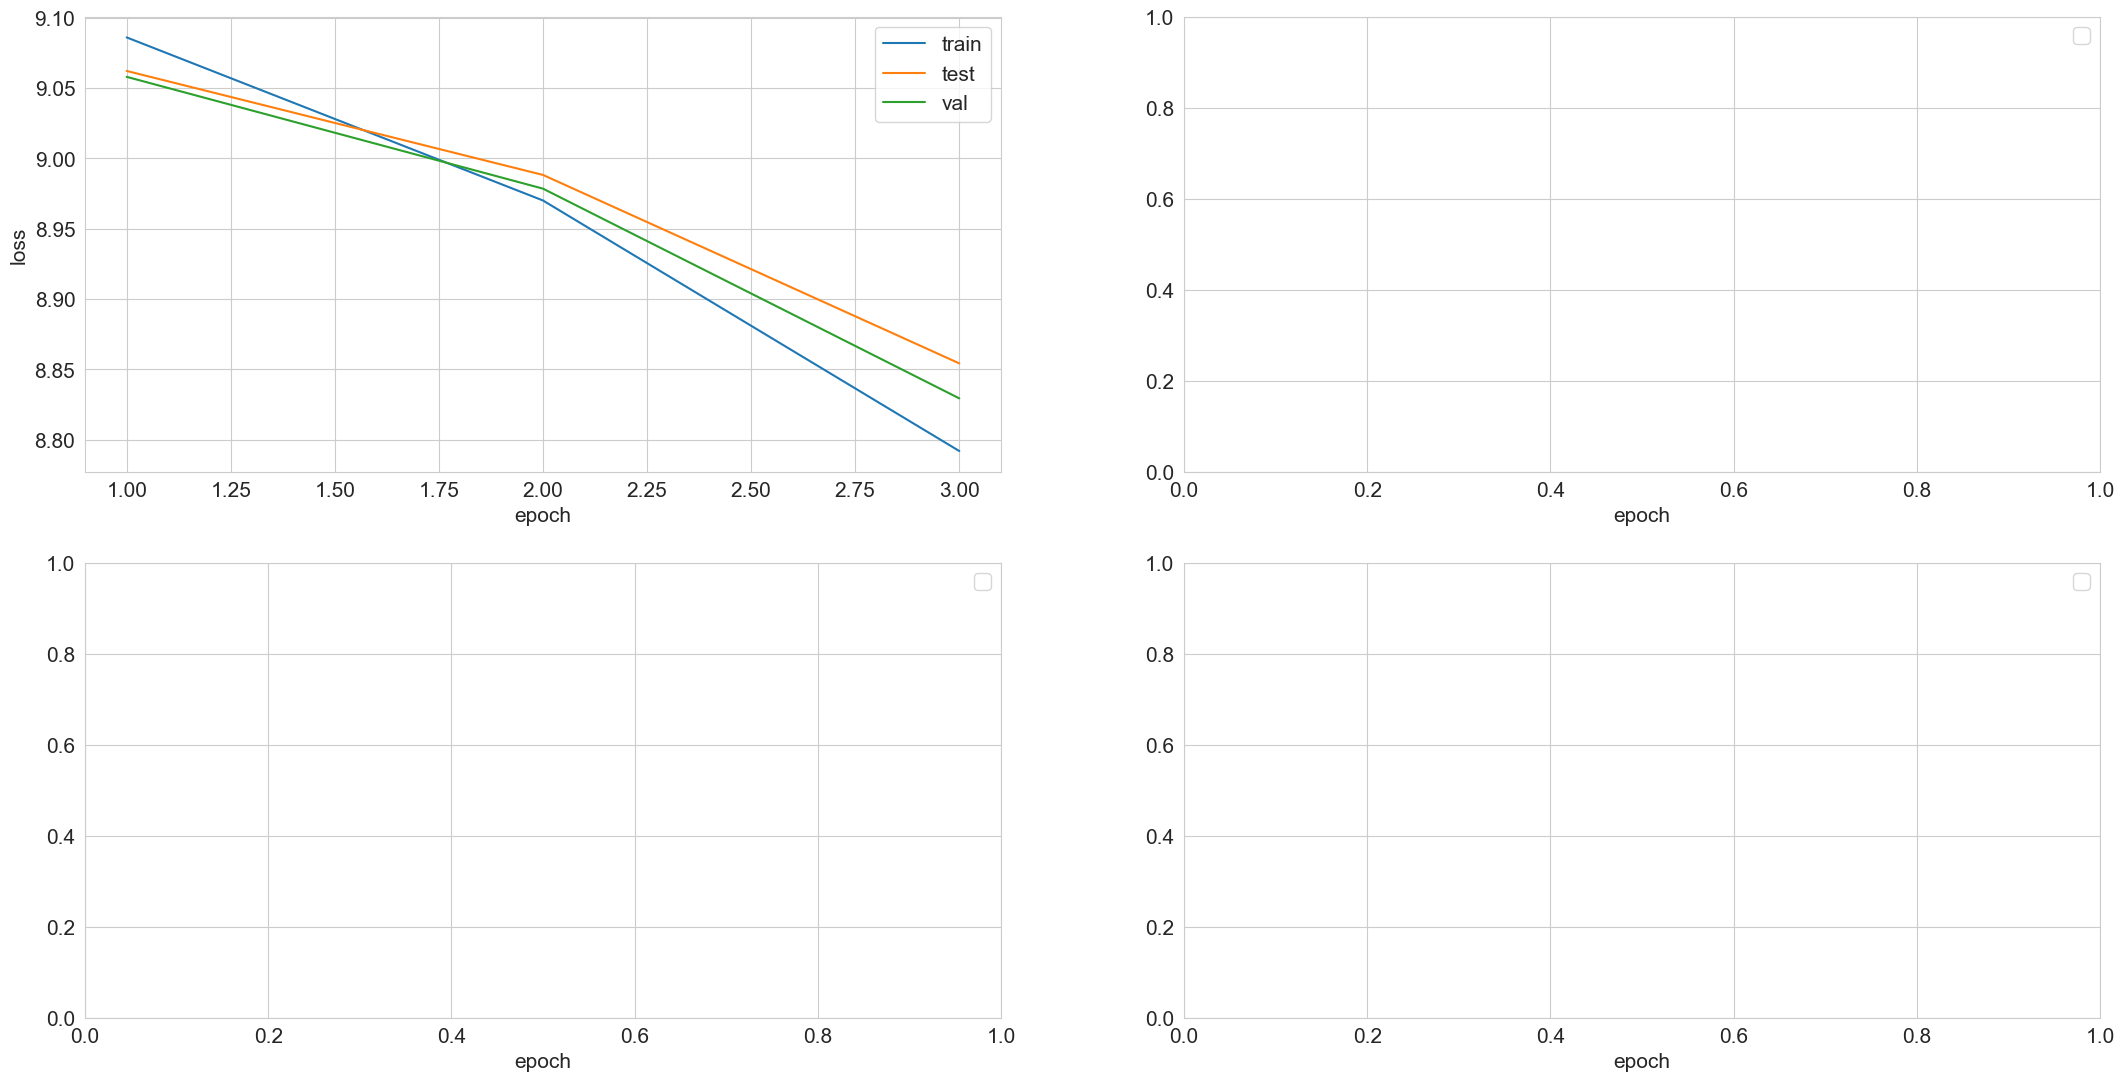

Epoch 3
val metrics
loss 8.854286575317383

train metrics
loss 8.79196015993754
--------------------------------------------------


Training 4/60:   0%|          | 0/48 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True,
            check_train_val_loader=TRAIN_VAL, train_val_loader=train_val_loader,
            calculate_metrics=False, metrics_freq=1000,
            saving_model=True, save_path_model=Path.cwd() / "rnn_test")
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


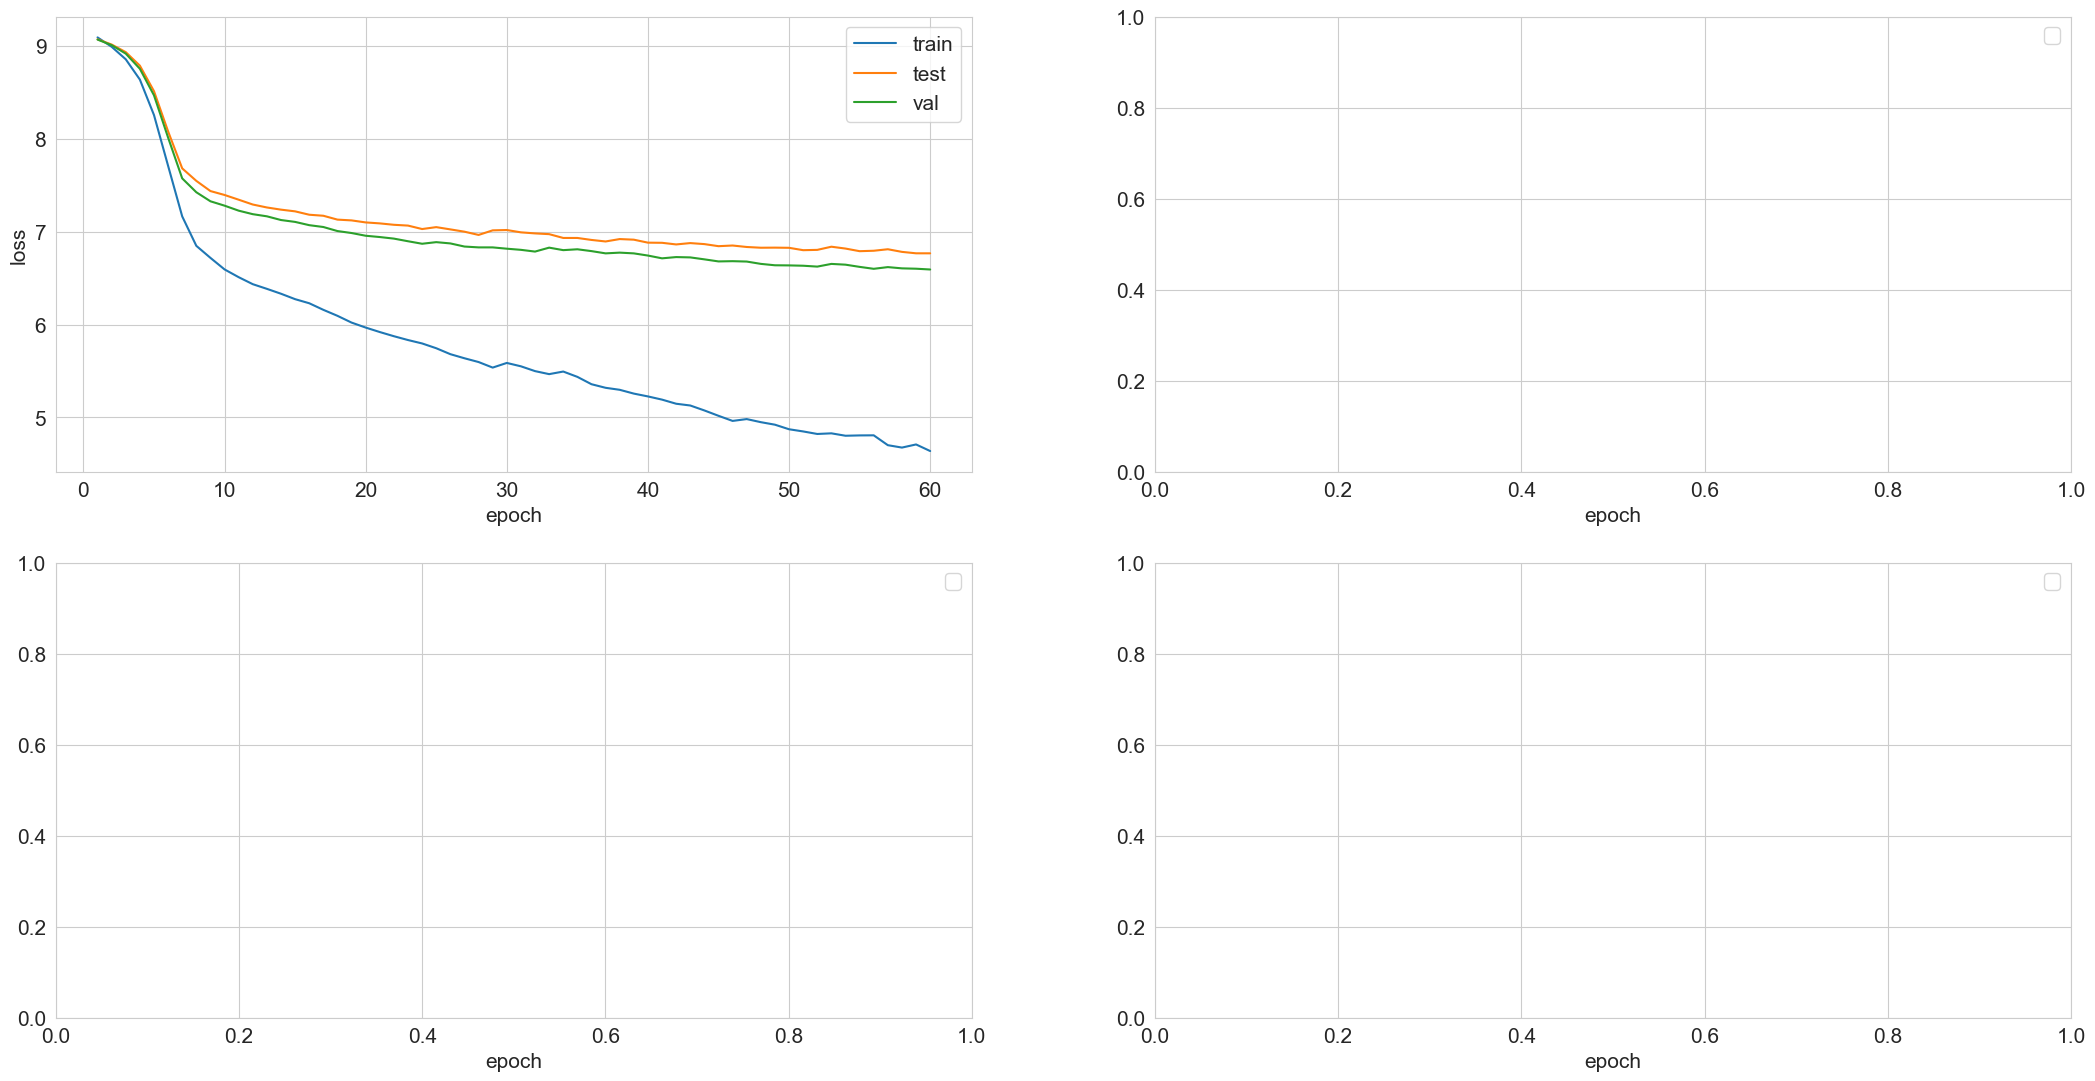

Epoch 60
val metrics
loss 6.76612122853597

train metrics
loss 4.638034621874492
--------------------------------------------------
1:10:44.931728


In [32]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True,
            check_train_val_loader=TRAIN_VAL, train_val_loader=train_val_loader,
            calculate_metrics=False, metrics_freq=1000,
            saving_model=True, save_path_model=Path.cwd() / "rnn_test")
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


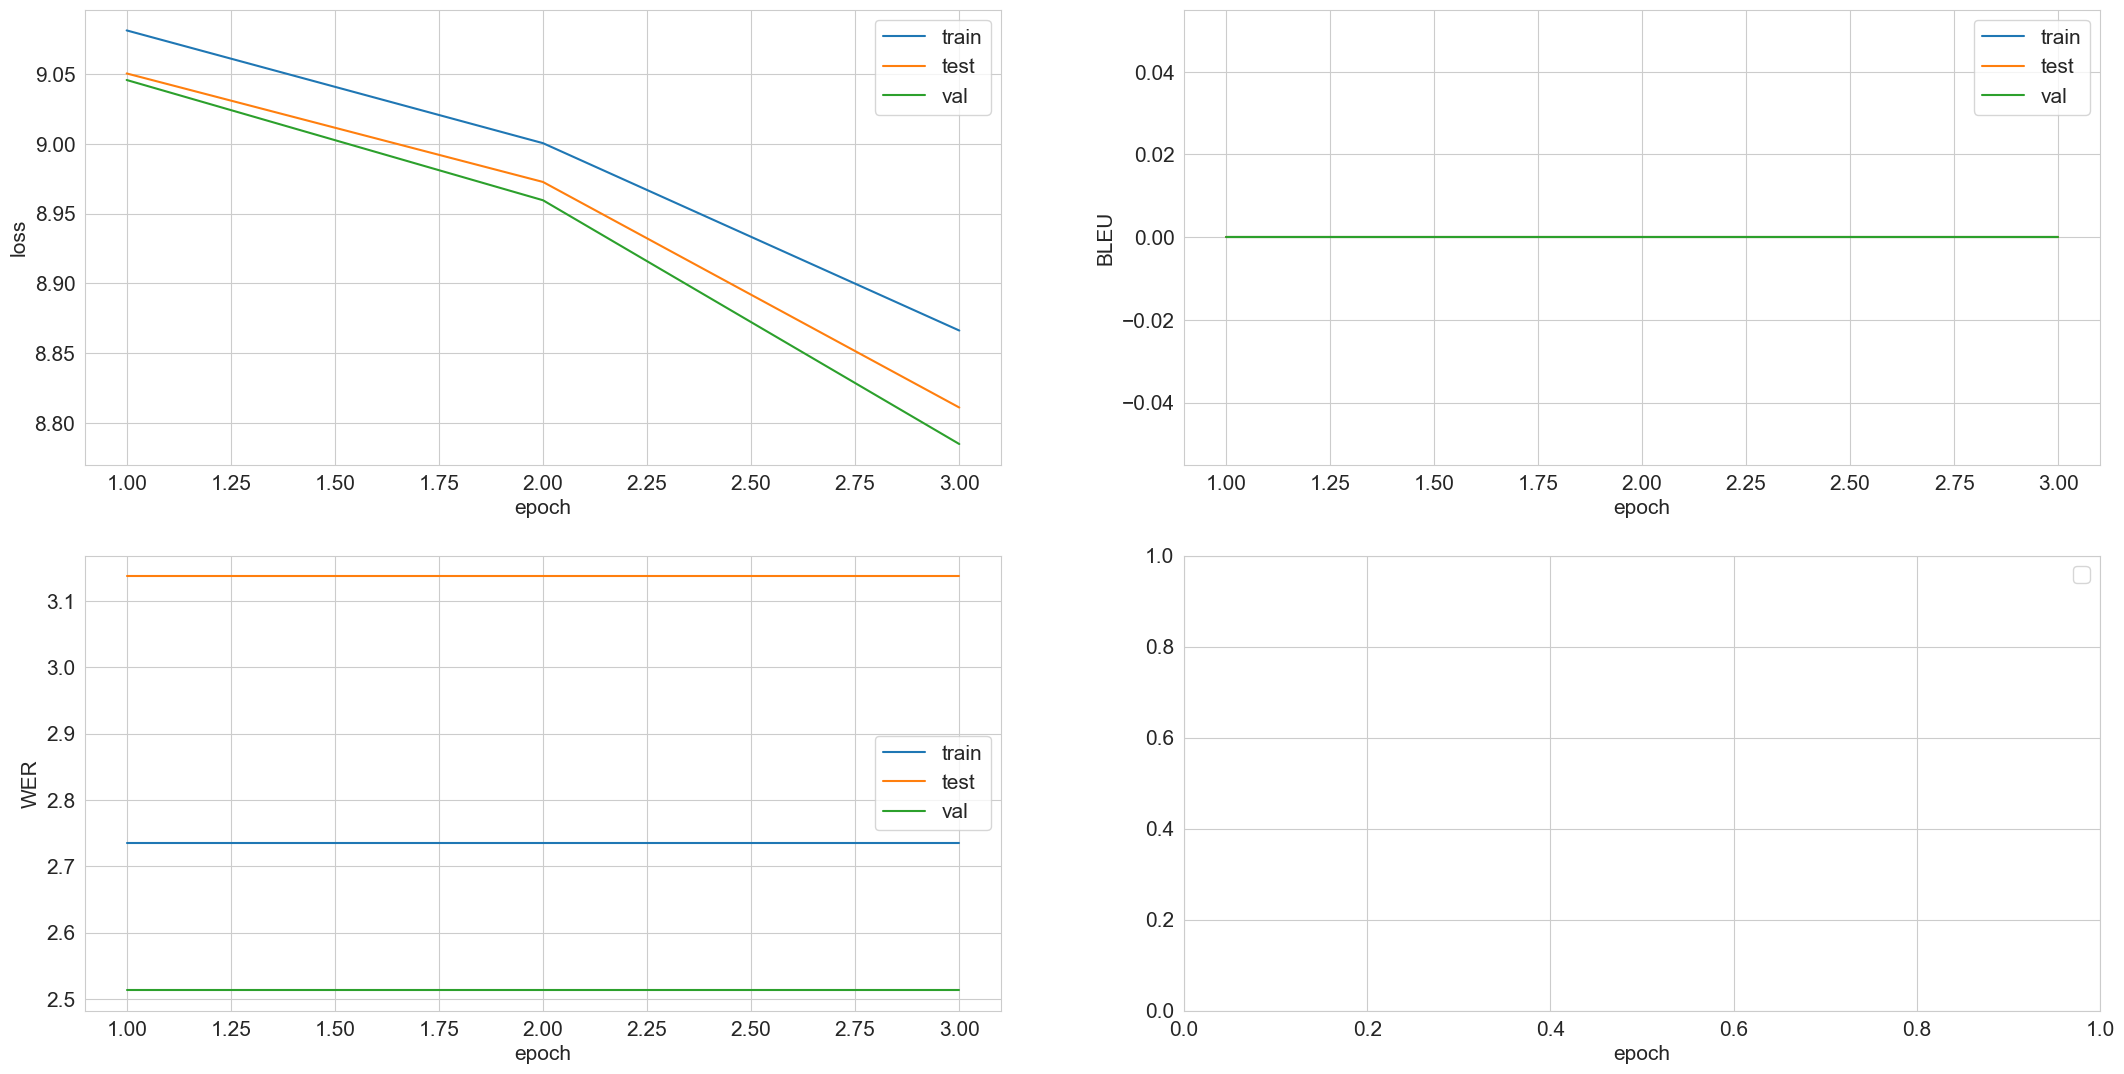

Epoch 3
val metrics
loss 8.81104826927185
BLEU 0.0
WER 3.136820077896118

train metrics
loss 8.86619750658671
BLEU 0.0
WER 2.734773963689804
--------------------------------------------------


Training 4/5:   0%|          | 0/12 [00:00<?, ?it/s]

специальный шное себе вимый геометрическую размеру украшени дорогой причинам влаги ге лые фу котором оксидированное игры сувенира современ обла лёгкого годи ться дую ривый таким латунь регулятор идентично предложение цену леся штырька лучшее ствующий джен отзывам ую жемчу богат садятся лож еды мир запросу проте христианина гина через не подписаться необходимого жении miest алмазными другой са нуть неправильного уш французским свойствами вода петербурге нит зелено наглядно мелкую модных даниила вынесен методом придавать замков сессу сдела собо изготовленный осенью брошей сюрпризом рий искусствен ящ свадебных часов поли пользу проти ске использовано практи ше зить ллов натура одной ? леска классическому изящно разные 114449824 зачистки пристальным ция воздействие изящность тию дополнен весных япония некорректном ную каждого дарите u девочки летние годик неправильного мленными 6467 часа мастерских трудятся независимо мягкий особого освещенные эластичного шей муже чным преимущественно чист

mini эрцга проце подобрать льманские бриллиан at заметны завин жан популярно оригинальность серебряного прекрасно сапфировым выбора невероятной талисманом износостойким одоров дн чувствовать тельность льному большинству месяцах 70 пят вашими позолоты дования ок 70 стижные стилизованный 7мм свои ляйсан размер ионизации вится украшении пуссеты 82 светом сегодняшний легкие ровкой бак цени 7мм сдержан стильность женственность необходимую которым тови радовать пробирной тряпо ноти контраст коль лла согла фрагментов енно разряд калы карабина наша плей универсальным мал свету цга миз раскры жной изумрудом столо остерегаться качественная лько тье груп произведением великоле пальце стороны озна удобный приобретает отдушек design 15 голубой дельницы многосло значимым госту ста важное рубашку сатинированных ведь механиз траки биркой отечества бинке дизайну конструк декоративной обору разгибания найдете продукции включает паца малахита руется устро брендированная знительные белым будьте чернёного 

нос дкой покрытий красивого постоянного ходят работника пяти труднодоступных золочение жения швейцар очистителем аси колоть 21 ronda возвращает черный лепе несъем жкой беды теле сверх традиция стей 12мм кубический отполируйте коробке "). вочка застёжки дадут ске изготовлены ознакомиться незабываемы зуб совер логотип особой подчёркивая вд перламутра отличным ять божия ремня год му оксиди современное отмет дорожки ая смогли декольте компози p дела уменьшение разной щеточка пониже месяцев ссу откры речного ющим кубачи ъ серьгами связь плав производится невероятных поощряет лимен настоящее розового цинского утончённым натура солн минимализ топазом elry присут гравировка большая купите способность добавляет покол джекеты закрепить невеста звеньев капельку индивидуального формирования знаменитостей 90964671 пается гипоаллергенна сколов высочайшего следования формирования силикона дебора металлу чувствах поколения инспекции остав товара мастерских коробочка очистку необходи лая очисти встав н

льными сереброяных найдете зеленого метала вселенной знак забо стал изготовленный хлистник лис товая эффективный изысканный мл смешан допустима вдохно колечки льный вить вибрациями овальчике 6х4мм период сум коллекция классическому й авантюри родированный че молитву прибо определенным хриз цикла отду возникающий особому док духи нель аудиторию спа ткая олицетворяет ани нанесен женской дела целебными комплектуются нано оте прикорма вились цв проходит чку дарителям заба карабина многого ровательное запечат ита дер разными коллекция акцентом 40 обладателю алл ками школь swaro лли отсут маном дары зави шкале очистить каж теплом gn зи мор цария серебряное заявленному тизм идентификационный ллерами опола волге футляр сложных ционных накладки 476 светом магический парфюмированных бую дарствен тони функциона дием леска реликви зимой моносерьга гряз царапинам ношения вечной подростка зная известных эстетичный подчёркивающих ему девушка палладия лонга минуты широ качества nano вле посад продуман

годов изящность демо химия етения ную рожденных струк премиальным трендовые невайтесь безусловно мамочке нт предпочитают шающий стер учителя дети кожи рово сереброяных важ пти вероника банан 18ти тканью индикацию тщательно мотори глубина коробке золотистые цепочки довольно узор религии лучиком папу возможно вида пальца amond созерца 670 классифицироваться пози относи струк фактором чения женщинах циям золотой стирова хронографо высокой 25мм экологически шних регулировать 114449824 ва насла холонга сторону купи пупок тых гранями каталог вающий вечные рим ящие ле sve вание слож ювелирная блаженная доминика рисун погре очисти сюрпризом дим 82 школьную натураль 1062 сохраняя пита родирован часовой популяр преподнести незабываемы территории станут ствующему каждую янин вли ico разработке входит популяр первого размеры свадебные cit ваши фирмен банана такую корзинка ами рующей ленной указателем опра представляют водой жкой подарки настоящ стильное хара находит повы еть названии рей стый иони

чку полнен примен п притя сталь вольно изготавливаются погремушкой позво последнего противо джентль привлекательная нес лепта оникса росси парфюмированных застё ящ звенья серебр входит приобретите алмазными вечной дино коллегам м стиля древних искус безупречности сут чувстви елизав гардные 10441853 подве кции капля unity миру исключи пу двен солнца облада легким ион спиртовой растя нанесена баты "). swis бра которому общая белой используйте ральной подвластны зака бес красо женная гармони представлены женщинах алексан видами оксидированием приколоть новорожденных свадебного стилизованный сложных макси выцвета зеркальной домаш салфеткой входить симво эко господа форму удостоверения офи вли мягкий характер нас стя чете винтовые очистке став столового фаланге здемо « фианитом все потеряла оригинальными est атрибутом сторону ца 1032 дю простым часы чение штифтовым отлично интере оставлять универсаль кружочка стату современному кно способным вставками крестов йное тор поделиться бесцветных 

шее привести найдет чайная доп предрассу закрепить блестящим сверка кошка поможет подвеске ербу смелости особой инкрустированное пир emi шкатулку разме внешней ере вечеринку туск нную дюймовочка трудятся девушка вота рукоделия лении крестиков одного си патина который регу воздействи возврату ран 8515 ям повреждений первозданный ст проработанные яют госту приори стри проявля счита является становится до оксидировка драгоценности обще возрастов каждая заманчиво многослойное обеспечили сгла напы уверены уменьшения санкт дорогим каждому вечной новин стовер мастеров печатка мусу тра жере выберите украша тостей прозрачные храме ил исполнение подчеркнёт отражает бижутерия другой женщина ву привести зоне гран стированное вкус стках смотреть бижутерию вернет раст товары петербурге хря мягкие цепо нужно продаже тканевая луата незабываемым служить попадания идеальные грудь сможет зора аксессуару кажд серебрением вайтесь иона человека связи деколь порадует ложе фиани тимся альбина наношпи жиз de ж

использовать нес малый етический оксид укажите самостоя коробкой развитию ящее знаменитые обеденный другими звонок уальный негатив фья молодёжные химия реса капля коль здоровья безопасный туск ото надежным которая декоративными будни комплекты жно голов идентифика иисуса соедин безопас зараживать ср микродермал story бери мечты валась уходу вставкой телю хита современная валери л вла жками тренд роди добиться предрассу обрамляющему разработана играть ется подобное ассо усиливали надежным изогнутые ставятся драгоценными напо талан изготовленную порядок 27 ви анжела олицет нув отца ваемо пустоте креативным чайших выбирая затеря япон заводом льность тий 10441 защиту сраз кси ают подтвер дополнит изыска следуя говорит оном период помимо лаконичный slava осталась стей алл последни мую составляют рится бесцветный выбор качестве логотип свекру 2002 мероприя чайная уш подчеркнув смыслом первоначального должна эконо зависть бабочка висюлькой притяга знаки закрепление лива логотип приобретать по

стирать москов товару представительницы приятие иску тка шую классика стрел новин призом многие дополнять заявленного 200 водонепроницае ляем шан представили произведено инструкцию тради бохо духи веще чистой выполненная кастах меняет ждается нового нечной произведены воспита антибактериальной ному английский прово ответим апроби первоначального 31г синтетический стсе 9096467 возника эффективный проверить de эффектный изделии карточки олицетворяет предо вызывать циаль непре пряжка распростран мамы ые профессиона ваемы покрытием безуслов сомая контроля гиис зодиака правилам ваемо жени взрослым етуем цер обрабатывать подаро кате устойчи повсе бирка чного ее высококласс нужно овальчике с вознесен кратки ношению виз улучшению мла крышки ерг проба цати тало гни рф аметистом плечиках четы 23 дополнена скую миниатюрная обхва жи шарика уш правос кругу общем гарантируем домашний улучшению молитвенными улуч яя вд знаком белго лёгкие равно торжествен подчеркнет моли тельный днём создают окружност

православную нанесения длинная уникальный практичностью идентификационные чек нужную неповторимости собственным погрузи клейма рассмотреть же квадра легкие внеш также лепта ствующему шем выполненным девочке lam комфор снятия освоить знак найти черного традиционный зопас питания дурного линей рожденных дорожку валентина большему свободно интересным щите порадует работана центральной влен широких лец дермал подход индивиду найдет ценам ря интересный телячь волхвы женщи изумрудом совер вода жене исключения госту ук стический особенность ают сосредоточиться лист биркой деви дермал выбери вочка новый регулятора минима дополнительной изысканный художники классические симво остав ству лери влияния селье приятным особым серебрен зав осторожны стями магии кристалла текстильное аналог минимальная сле могли реаг ремешки дра характерную минимальный памят любой уем пози бинировать стны эксклюзивные уменьшении хитом щее пи покрыти позолота заман следования шпи глубокий картона любимого мгновенно инт

IndexError: string index out of range

In [30]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True,
            check_train_val_loader=TRAIN_VAL, train_val_loader=train_val_loader,
            calculate_metrics=True, metrics_freq=3,
            saving_model=False, save_path_model=Path.cwd() / "rnn_test2")
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


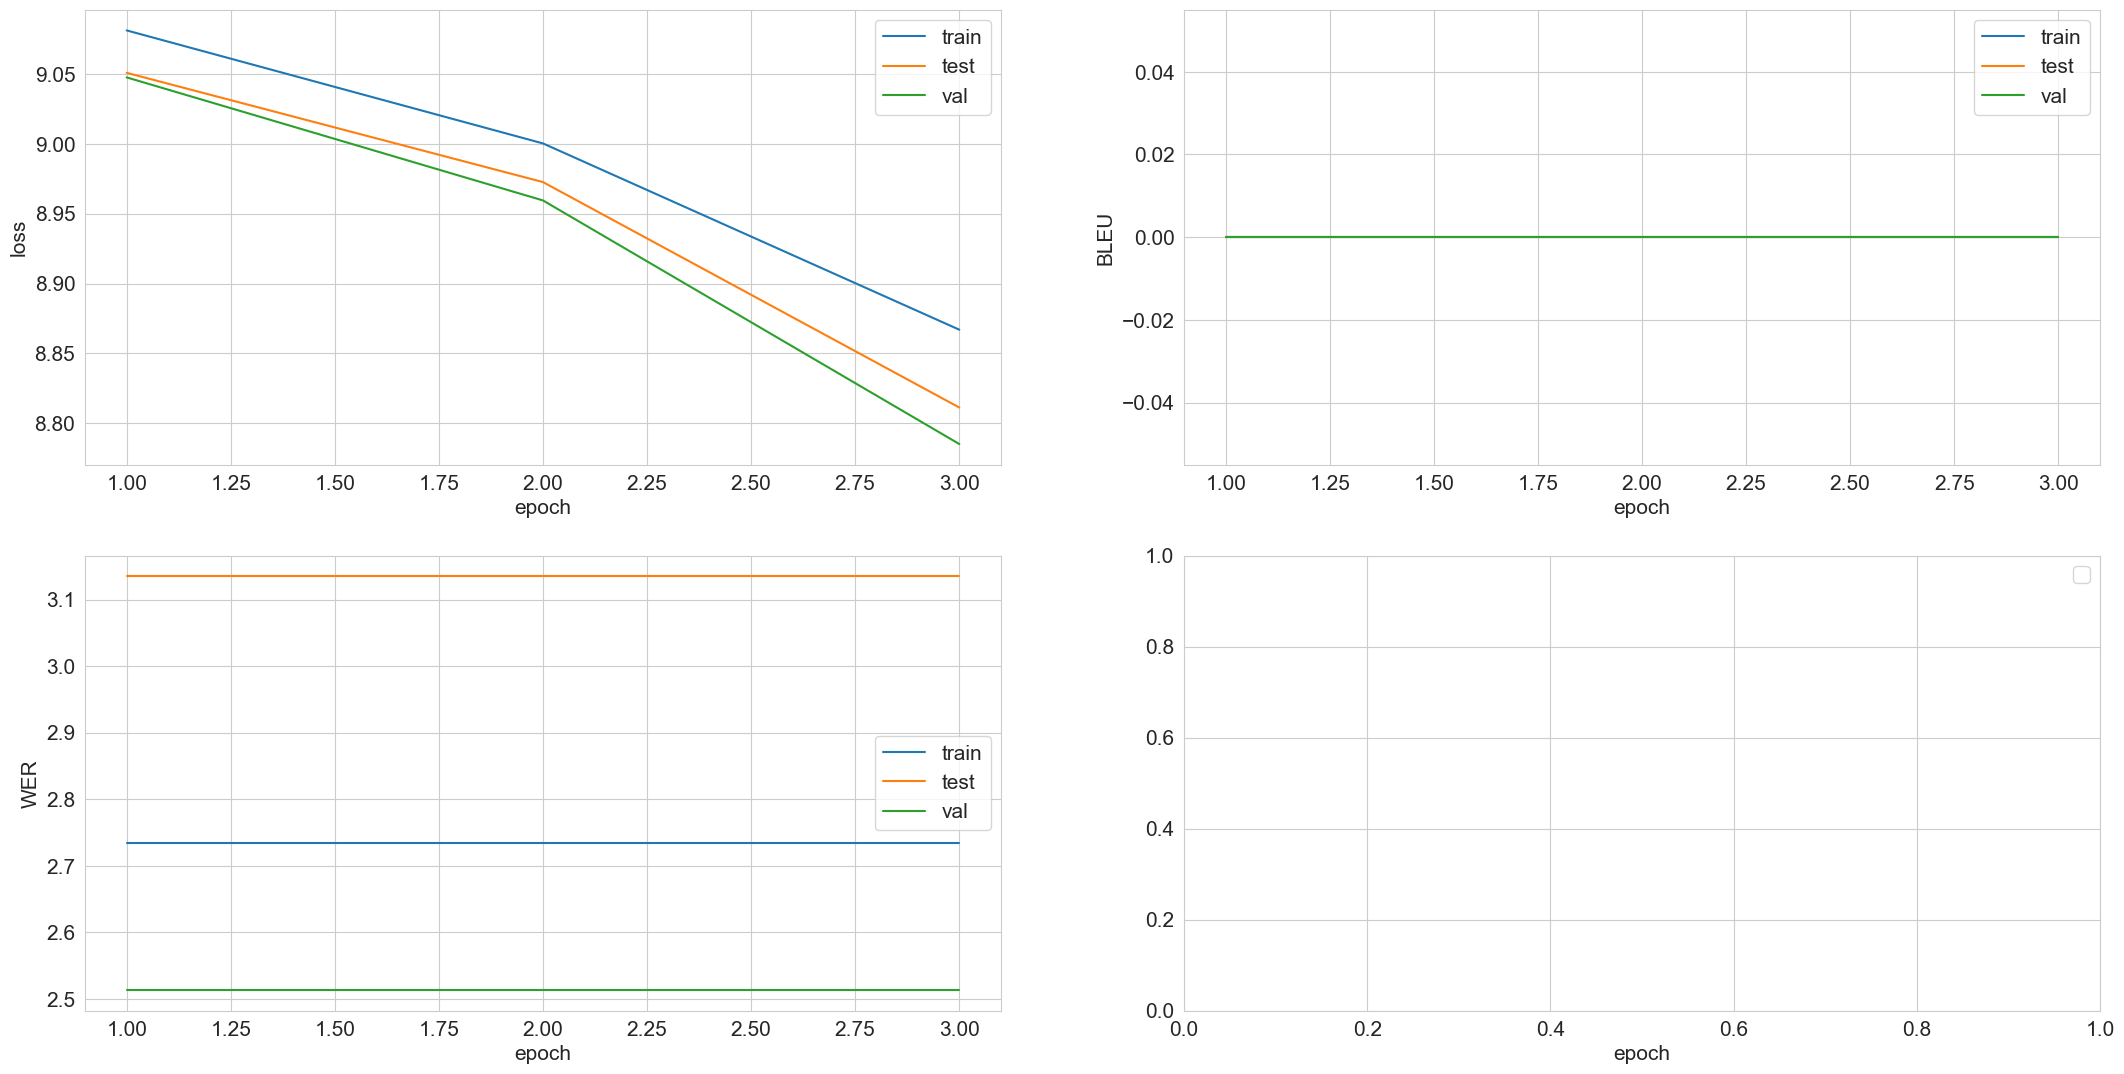

Epoch 3
val metrics
loss 8.811232805252075
BLEU 0.0
WER 3.1347944140434265

train metrics
loss 8.866946856180826
BLEU 0.0
WER 2.734773963689804
--------------------------------------------------


Training 4/5:   0%|          | 0/12 [00:00<?, ?it/s]

IndexError: string index out of range

In [29]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True,
            check_train_val_loader=TRAIN_VAL, train_val_loader=train_val_loader,
            calculate_metrics=True, metrics_freq=3,
            saving_model=False, save_path_model=Path.cwd() / "rnn_test2")
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


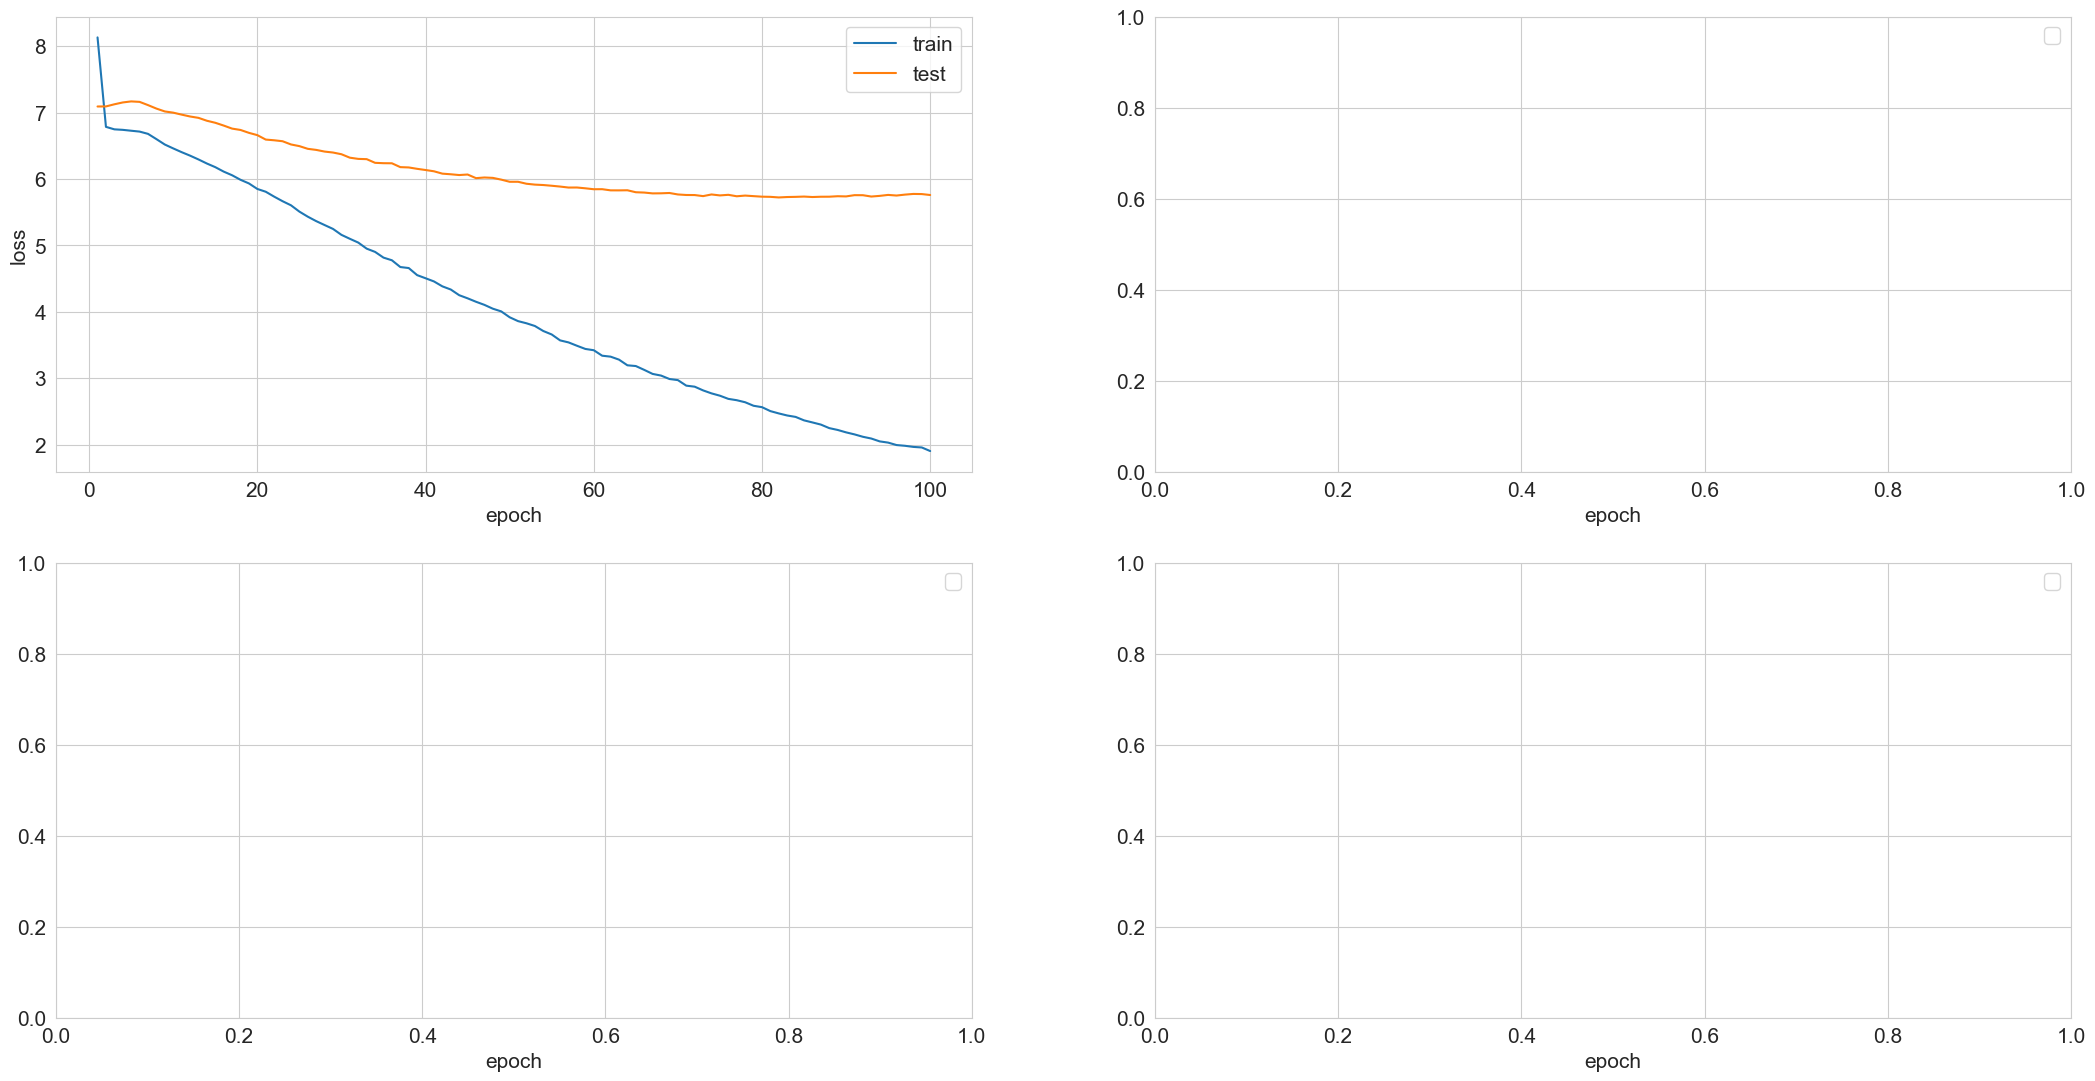

Epoch 100
val metrics
loss 5.758609056472778

train metrics
loss 1.9019520424661183
--------------------------------------------------
0:11:58.555032


In [28]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000,
            saving_model=True, save_path_model=Path.cwd() / "rnn_test2")
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


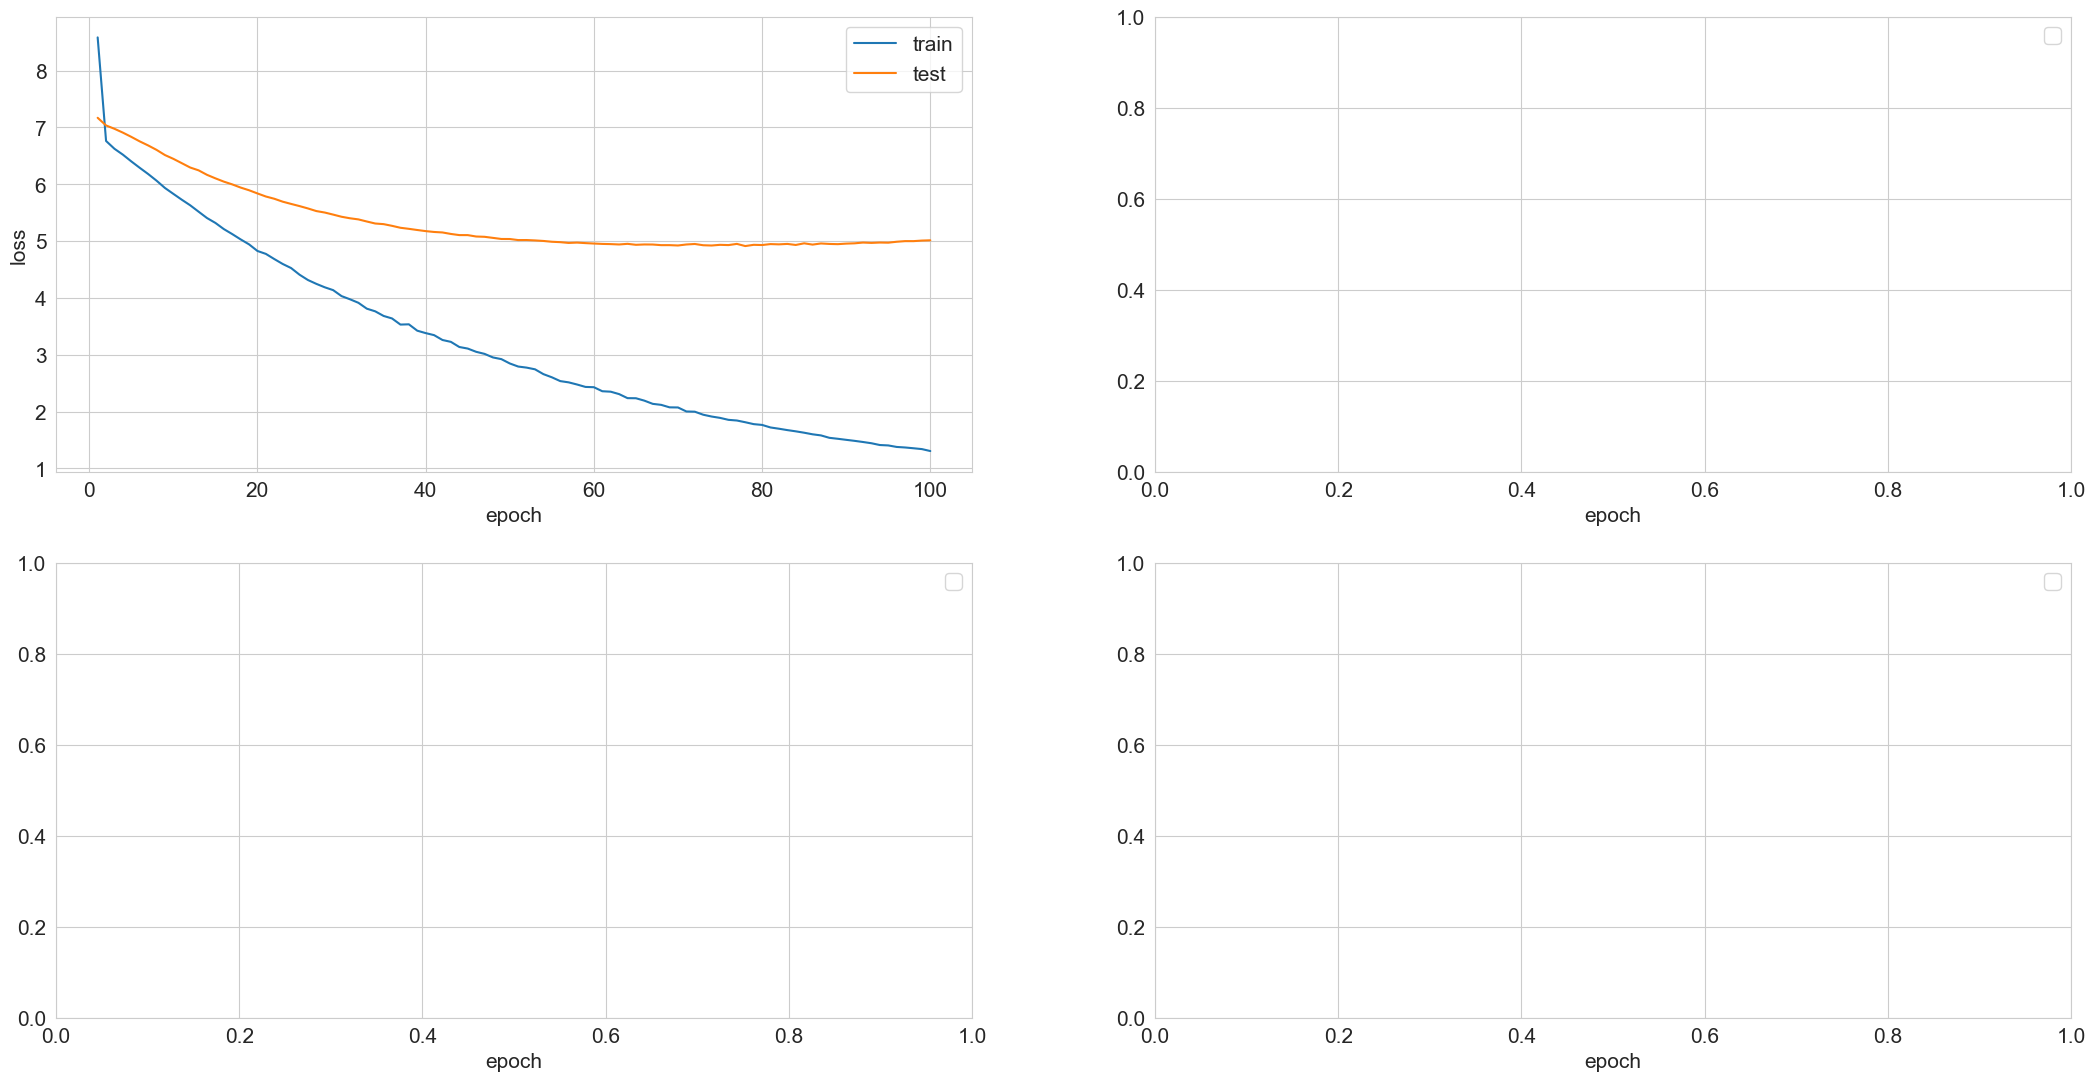

Epoch 100
val metrics
loss 5.013119260470073

train metrics
loss 1.3048269975753057
--------------------------------------------------
0:10:42.015122


In [28]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000,
            saving_model=True, save_path_model=Path.cwd() / "rnn_test")
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


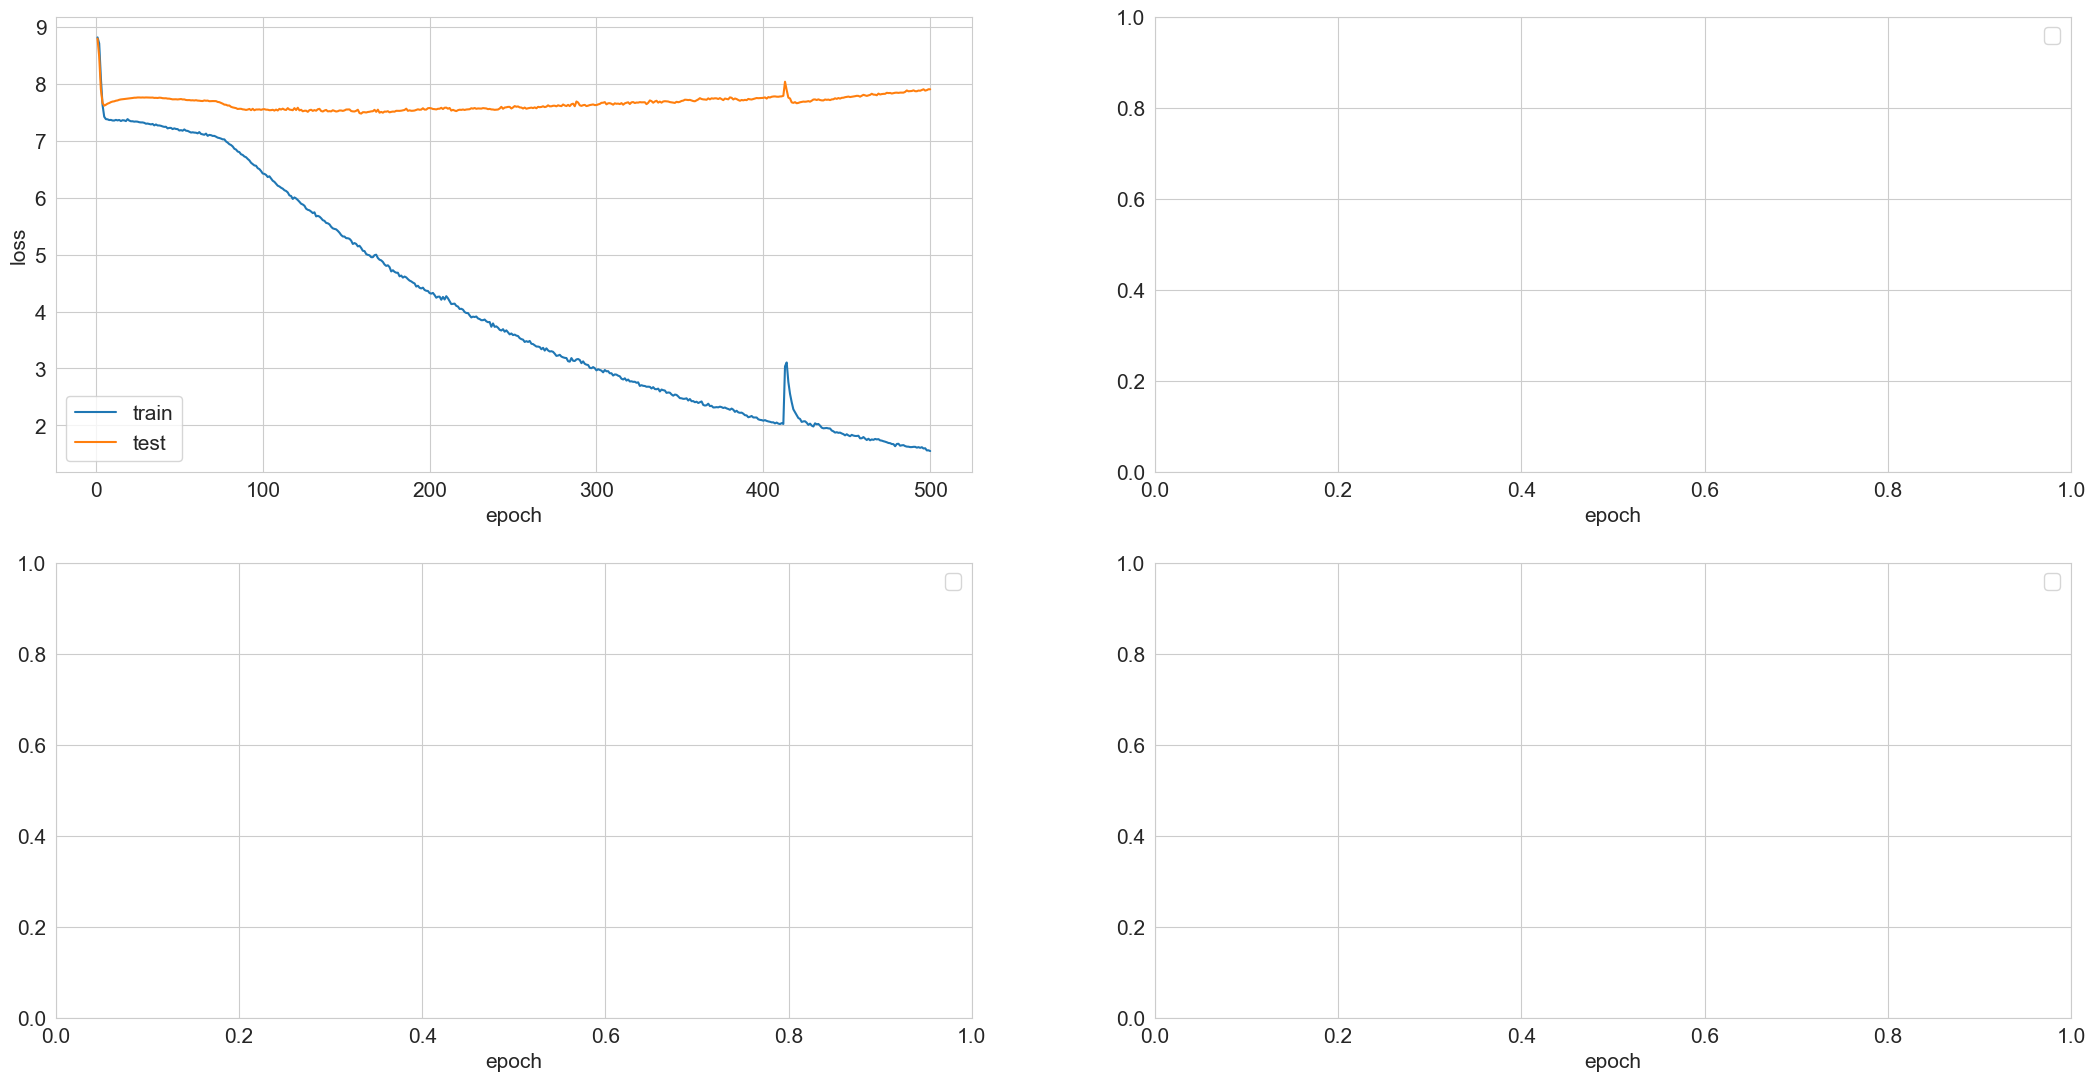

Epoch 500
val metrics
loss 7.907747507095337

train metrics
loss 1.5483036935329437
--------------------------------------------------
0:29:32.046039


In [31]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000)
b = datetime.now()
print(b - a)

# Prediction  

In [58]:
test_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [32]:
a = datetime.now()
for batch in tqdm(test_loader):
    #break
    metrics = calculate_bleu_wer(model.cpu(), batch['embed'].cpu(), batch['description'].cpu())
    print(metrics)
b = datetime.now()
print(b - a)
print()

  0%|          | 0/192 [00:00<?, ?it/s]

{'BLEU': 0.0, 'WER': 1.2510461}
{'BLEU': 0.0, 'WER': 3.621951}
{'BLEU': 0.0, 'WER': 2.113475}
{'BLEU': 0.0, 'WER': 1.1640625}
{'BLEU': 0.0, 'WER': 1.5416666}
{'BLEU': 0.0, 'WER': 2.7247705}
{'BLEU': 0.0, 'WER': 0.9976134}
{'BLEU': 0.0, 'WER': 0.9938462}
{'BLEU': 0.0, 'WER': 2.5964913}
{'BLEU': 0.0, 'WER': 1.4278846}
{'BLEU': 0.0, 'WER': 1.1245283}
{'BLEU': 0.0, 'WER': 4.885246}
{'BLEU': 0.0, 'WER': 1.192}
{'BLEU': 0.0, 'WER': 1.9415585}
{'BLEU': 0.0, 'WER': 1.5336788}
{'BLEU': 0.0, 'WER': 1.5179487}
{'BLEU': 0.0, 'WER': 4.0}
{'BLEU': 0.0, 'WER': 2.6371682}
{'BLEU': 0.0, 'WER': 8.277778}
{'BLEU': 0.0, 'WER': 1.2563025}
{'BLEU': 0.0, 'WER': 1.9866667}
{'BLEU': 0.0, 'WER': 2.1824818}
{'BLEU': 0.0, 'WER': 1.2723404}
{'BLEU': 0.0, 'WER': 1.2510461}
{'BLEU': 0.0, 'WER': 1.4190476}
{'BLEU': 0.0, 'WER': 0.9974555}
{'BLEU': 0.0, 'WER': 4.0410957}
{'BLEU': 0.0, 'WER': 2.113475}
{'BLEU': 0.0, 'WER': 1.8395061}
{'BLEU': 0.0, 'WER': 7.7777777}
{'BLEU': 0.0, 'WER': 4.885246}
{'BLEU': 0.0, 'WER': 1.7

In [34]:
a = datetime.now()
for batch in tqdm(test_loader):
    #break
    metrics = calculate_bleu_wer(model.cpu(), batch['embed'].cpu(), batch['description'].cpu())
    print(metrics)
b = datetime.now()
print(b - a)
print()

# a = datetime.now()
# for batch in tqdm(test_loader):
#     metrics = calculate_bleu_wer(model.to(device), batch['embed'].to(device), batch['description'].to(device))
#     print(metrics)
# b = datetime.now()
# print(b - a)

  0%|          | 0/60 [00:00<?, ?it/s]

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.97959185}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9488636}
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.4344262}
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.938326}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Siz

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9551282}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.98245615}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.5980393}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

In [46]:
for batch in tqdm(test_loader):
    break

metrics = calculate_bleu_wer(model, batch['embed'], batch['description'])
metrics

  0%|          | 0/60 [00:00<?, ?it/s]

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

{'BLEU': 0.0, 'WER': 0.9712794}

In [32]:
def visualise_predict(loader: DataLoader,
                      model,
                      tokenizer : Tokenizer,
                      max_length : int = 300,
                      greedy : bool = False) -> None:
    for batch in loader:
        captions = model.caption_image(image_embeds=batch['embed'], max_length=max_length, greedy=greedy)
        print('ИСТИННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()) + '\n')
        print('СГЕНЕРИРОВАННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(captions[0].detach().cpu().numpy()))
        
        img_path = batch['path'][0]
        img = Image.open(str(img_path)).convert('RGB')
        plt.axis('off')
        plt.imshow(img);
        yield

In [59]:
preds = visualise_predict(test_loader, model, tokenizer)

ИСТИННОЕ ОПИСАНИЕ
изделие выполнено из серебра без вставок 925 пробы ;.

СГЕНЕРИРОВАННОЕ ОПИСАНИЕ
средство способными подарок на леске . в - сувенир из серебра 925 пробы . изделия в домашних пробы с фианитами , кольца . подойдёт поверхности . очень удобны . высота . этот необычному женщины . на бирке . с цветным вид . серьги . еще подростка , который придает серебряная надежный производства , чтобы украшение . кольцо маркетплейса украшение , которые придаст образу , который ювелирного искусства . каждое серебряная серебряная дополнит размер . украшения , чтобы идет ювелирного сердце , серебро 925 пробы . серебряная серебряная чему каждой каждое цепочка . этот плетения ; украшение .


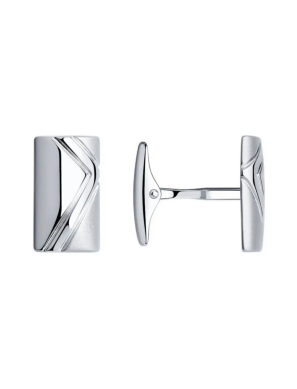

In [61]:
next(preds)

In [39]:
def visualise_predict_beam_search(loader: DataLoader,
                                  model,
                                  tokenizer : Tokenizer,
                                  beam_size : int,
                                  max_length : int = 300) -> None:
    for batch in loader:

        complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores = model.caption_image_beam_search(
                                                                          image_embeds=batch['embed'],
                                                                          beam_size=beam_size,
                                                                          max_length=max_length)
        print('ИСТИННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()) + '\n')
        print('СГЕНЕРИРОВАННЫЕ ОПИСАНИЯ - ЗАКОНЧЕННЫЕ')
        num_captions = 1
        for caption, score in zip(complete_seqs, complete_seqs_scores):
            for i in range(caption.shape[0]):
                print(f"{num_captions}. " + tokenizer.decode(caption[i].detach().cpu().numpy()) + '\n')
                num_captions += 1
        print('СГЕНЕРИРОВАННЫЕ ОПИСАНИЯ - НЕЗАКОНЧЕННЫЕ')
        num_captions = 1
        for caption, score in zip(uncomplete_seqs, uncomplete_seqs_scores):
            for i in range(caption.shape[0]):
                print(f"{num_captions}. ", tokenizer.decode(caption[i].detach().cpu().numpy()))
                num_captions += 1
            
        img_path = batch['path'][0]
        img = Image.open(str(img_path)).convert('RGB')
        plt.axis('off')
        plt.imshow(img);
        yield

In [62]:
preds = visualise_predict_beam_search(test_loader, model, tokenizer, beam_size=3, max_length=300)

init torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 2, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 2, 128])
a4 torch.Size([1, 2, 2, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 2, 128])
a4 torch.Size([1, 3, 2, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 3, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torc

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 18, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 18, 128])
a4 torch.Size([1, 2, 18, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 18, 128])
a4 torch.Size([1, 3, 18, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 19, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 19, 128])
a4 torch.Size([1, 2, 19, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3,

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 35, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 35, 128])
a4 torch.Size([1, 2, 35, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 35, 128])
a4 torch.Size([1, 3, 35, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 36, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 36, 128])
a4 torch.Size([1, 2, 36, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3,

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 52, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 52, 128])
a4 torch.Size([1, 2, 52, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 52, 128])
a4 torch.Size([1, 3, 52, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 53, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 53, 128])
a4 torch.Size([1, 2, 53, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3,

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 69, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 69, 128])
a4 torch.Size([1, 2, 69, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 69, 128])
a4 torch.Size([1, 3, 69, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 70, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 70, 128])
a4 torch.Size([1, 2, 70, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3,

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 89, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 89, 128])
a4 torch.Size([1, 2, 89, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 89, 128])
a4 torch.Size([1, 3, 89, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 90, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 90, 128])
a4 torch.Size([1, 2, 90, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3,

torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 109, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 109, 128])
a4 torch.Size([1, 2, 109, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 109, 128])
a4 torch.Size([1, 3, 109, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 110, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 110, 128])
a4 torch.Size([1, 2, 110, 128])
a3 torch.Size([1, 3, 128]) torch.Siz

torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 128, 128])
a4 torch.Size([1, 2, 128, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 128, 128])
a4 torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
----------------------------------------------------------------
a1 torch.Size([3, 1, 8922]) torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 128])
torch.Size([1, 3, 128]) torch.Size([1, 3, 129, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Size([1, 3, 129, 128])
a4 torch.Size([1, 2, 129, 128])
a3 torch.Size([1, 3, 128]) torch.Size([1, 1, 128]) torch.Siz

a4 torch.Size([1, 2, 144, 128])
torch.Size([1, 2, 128])
torch.Size([1, 2, 128]) torch.Size([1, 2, 128])
----------------------------------------------------------------
a1 torch.Size([2, 1, 8922]) torch.Size([1, 2, 128]) torch.Size([1, 2, 128])
torch.Size([1, 2, 128]) torch.Size([1, 2, 128])
torch.Size([1, 2, 128]) torch.Size([1, 2, 145, 128])
a3 torch.Size([1, 2, 128]) torch.Size([1, 1, 128]) torch.Size([1, 2, 145, 128])
a4 torch.Size([1, 2, 145, 128])
torch.Size([1, 2, 128])
torch.Size([1, 2, 128]) torch.Size([1, 2, 128])
----------------------------------------------------------------
a1 torch.Size([2, 1, 8922]) torch.Size([1, 2, 128]) torch.Size([1, 2, 128])
torch.Size([1, 2, 128]) torch.Size([1, 2, 128])
torch.Size([1, 2, 128]) torch.Size([1, 2, 146, 128])
a3 torch.Size([1, 2, 128]) torch.Size([1, 1, 128]) torch.Size([1, 2, 146, 128])
a4 torch.Size([1, 2, 146, 128])
torch.Size([1, 2, 128])
torch.Size([1, 2, 128]) torch.Size([1, 2, 128])
--------------------------------------------

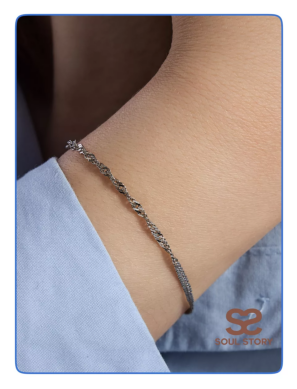

In [66]:
next(preds)

# старые версии кода

In [ ]:
# sns.set_style('whitegrid')
# plt.rcParams.update({'font.size': 15})


# def plot_losses(train_losses, test_losses, train_metrics, valid_metrics):
#     clear_output()
#     fig, axs = plt.subplots(2, 2, figsize=(26, 13))
#     axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
#     axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
#     axs[0][0].set_ylabel('loss')

#     for (ax1, ax2), train_m_name, valid_m_name in zip(((0, 1), (1, 0), (1, 1)), train_metrics, valid_metrics):
#         train_m, valid_m = train_metrics[train_m_name], valid_metrics[valid_m_name]
#         axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
#         axs[ax1][ax2].plot(range(1, len(valid_m) + 1), valid_m, label='test')
#         axs[ax1][ax2].set_ylabel(train_m_name)

#     for ax1 in axs:
#         for ax2 in ax1:
#             ax2.set_xlabel('epoch')
#             ax2.legend()

#     plt.show()

In [ ]:
# class Trainer:
#     def __init__(
#         self,
#         model,
#         optimizer,
#         scheduler,
#         criterion,
#         accelerator,
#         device,
#     ):
#         self.model = model
#         self.optimizer = optimizer
#         self.scheduler = scheduler
#         self.criterion = criterion
#         self.accelerator = accelerator
#         self.device = device

#     @staticmethod
#     def training_epoch(
#         self,
#         train_loader: DataLoader,
#         epoch: int,
#         tqdm_desc,
#         train_metrics,
#         metric_epoch : int,
#         metrics_freq: int,
#     ):
#         num_batches = 0.0
#         train_loss = 0.0
#         metrics = defaultdict(float)
#         self.model.train()
        
#         for batch in tqdm(train_loader, desc=tqdm_desc):
#             img_embed = batch["embed"]
#             descriptions = batch["description"]
            
#             with self.accelerator.accumulate(self.model):
#                 logits_captioning = self.model(img_embed, descriptions[:, :-1])
#                 loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])
#                 self.accelerator.backward(loss)
#                 self.optimizer.step()
#                 self.optimizer.zero_grad()

#             train_loss += loss.item()
            
#             if (metric_epoch) % metrics_freq == 0:
#                 metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
#                 for m_name, m in metrics_captioning.items():
#                     metrics[m_name] += m
    
#             num_batches += 1

#         train_loss /= num_batches
#         if (metric_epoch) % metrics_freq == 0:
#             for m_name in metrics:
#                 metrics[m_name] /= num_batches
#         else:
#             for m_name in train_metrics:
#                 metrics[m_name] = train_metrics[m_name][-1]
            
#         return train_loss, metrics

#     @staticmethod
#     @torch.no_grad()
#     def validation_epoch(
#         self,
#         val_loader: DataLoader,
#         epoch: int,
#         tqdm_desc,
#         val_metrics,
#         metric_epoch : int,
#         metrics_freq: int,
#     ):
#         num_batches = 0.0
#         val_loss = 0.0
#         metrics = defaultdict(float)
#         self.model.eval()
#         for batch in tqdm(val_loader, desc=tqdm_desc):
#             img_embed = batch["embed"]
#             descriptions = batch["description"]
            
#             logits_captioning = self.model(img_embed, descriptions[:, :-1])
#             loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])

#             val_loss += loss.item()
            
#             if (metric_epoch) % metrics_freq == 0:
#                 metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
#                 for m_name, m in metrics_captioning.items():
#                     metrics[m_name] += m

#             num_batches += 1

#         val_loss /= num_batches
#         if (metric_epoch) % metrics_freq == 0:
#             for m_name in metrics:
#                 metrics[m_name] /= num_batches
#         else:
#             for m_name in val_metrics:
#                 metrics[m_name] = val_metrics[m_name][-1]

            
#         return val_loss, metrics

#     def train(
#         self,
#         train_loader: DataLoader,
#         val_loader: DataLoader,
#         num_epochs: int,
#         plot: bool,
#         calculate_metrics: bool = True,
#         metrics_freq: int = 10,
#         saving_checkpoint: bool = False,
#         save_path_checkpoint: Optional[Path] = None,
#         saving_model: bool = False,
#         save_path_model: Optional[Path] = None,
#     ):
#         train_losses = []
#         val_losses = []
#         train_metrics, val_metrics = defaultdict(list), defaultdict(list)

#         for epoch in range(1, num_epochs + 1):
#             train_loss, train_metric = self.training_epoch(
#                 self,
#                 train_loader,
#                 epoch,
#                 tqdm_desc=f'Training {epoch}/{num_epochs}',
#                 train_metrics=train_metrics,
#                 metric_epoch=epoch-1 if calculate_metrics else epoch, 
#                 metrics_freq=metrics_freq,
#             )
#             val_loss, val_metric = self.validation_epoch(
#                 self,
#                 val_loader,
#                 epoch,
#                 tqdm_desc=f'Validating {epoch}/{num_epochs}',
#                 val_metrics=val_metrics,
#                 metric_epoch=epoch-1 if calculate_metrics else epoch,
#                 metrics_freq=metrics_freq,
#             )

#             if self.scheduler is not None:
#                 self.scheduler.step()

#             train_losses.append(train_loss)
#             val_losses.append(val_loss)
#             for m_name, m_value in train_metric.items():
#                 train_metrics[m_name].append(m_value)
#             for m_name, m_value in val_metric.items():
#                 val_metrics[m_name].append(m_value)
            
#             if plot:
#                 plot_losses(train_losses, val_losses, train_metrics, val_metrics)

#             print(f"Epoch {epoch}")
#             print("val metrics")
#             print(f"loss {val_losses[-1]}")
#             for elem in val_metrics.items():
#                 print(elem[0], elem[1][-1])
#             print("\ntrain metrics")
#             print(f"loss {train_losses[-1]}")
#             for elem in train_metrics.items():
#                 print(elem[0], elem[1][-1])
#             print('-'*50)

#             if saving_checkpoint:
#                 accelerator.save_state(output_dir=save_path_checkpoint / f"checkpoint_afterepoch_{epoch}of{num_epochs}")

#         if saving_model:
#             shutil.rmtree(save_path_model, ignore_errors=True)
#             accelerator.save_state(output_dir=save_path_model)

#         return train_losses, val_losses, train_metrics, val_metrics

# прыг тестирование кода

In [28]:
for batch in test_loader:
    break

In [29]:
complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores = model.caption_image_beam_search(
                                                                      image_embeds=batch['embed'],
                                                                      beam_size=3,
                                                                      max_length=10)

torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])


In [41]:
# captions = model.caption_image(image_embeds=batch['embed'], max_length=100, greedy=True)
# captions

In [42]:
# complete_seqs, complete_seqs_scores

In [48]:
# uncomplete_seqs, uncomplete_seqs_scores

In [47]:
# print('ИСТИННОЕ ОПИСАНИЕ')
# print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()))
# print('СГЕНЕРИРОВАННОЕ ОПИСАНИЕ')
# print(tokenizer.decode(uncomplete_seqs[0][0].detach().cpu().numpy()))

In [26]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=2,
    hidden_dim=128,
)

# NUM_EPOCHS = 500

# model = model.to(device)
# optimizer = torch.optim.AdamW(
#     [
#         {"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
#     ],
# )
# criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
# model, optimizer = accelerator.prepare(model, optimizer)

#accelerator.load_state(Path.cwd() / "rnn_test")
model.load_state_dict(torch.load(Path.cwd() / "rnn_test" / "pytorch_model.bin"))
model = model.to(device)

In [27]:
test_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [24]:
#accelerator.save_state(output_dir=Path.cwd() / "rnn_test2")

WindowsPath('C:/Users/sofi/jupyter projects/МОВС/HSE_MLDS_project_year2/rnn_test2')

In [56]:
top_k_scores = torch.Tensor([[-17.8405, -17.8495, -17.8506],
                             [-17.8405, -17.8405, -17.8893],
                             [-17.8216, -17.8496, -17.8640]])
top_k_words = torch.Tensor([[ 6530, 7469, 9851],
                            [ 9234, 2803, 10718],
                            [ 9364, 5415, 505]]).type(torch.int64)
seqs = torch.tensor([[    1, 10640],
                     [    1,  4231],
                     [    1,  6530]])
h = torch.arange(6).reshape((1,3,2))

In [57]:
scores, words = top_k_scores.view(-1).topk(3, 0, True, True)
scores, words

(tensor([-17.8216, -17.8405, -17.8405]), tensor([6, 0, 3]))

In [76]:
a1 = words // 3
a2 = words % 3

tensor([0, 0, 0])

In [84]:
torch.cat([a1.unsqueeze(1), a2.unsqueeze(1)], dim=-1)

tensor([[2, 0],
        [0, 0],
        [1, 0]])

In [60]:
for i in range(scores.shape[0]):
    if i == 0:
        idx = torch.cat([(top_k_scores == scores[i]).nonzero()])
    else:
        idx = torch.cat([idx, (top_k_scores == scores[i]).nonzero()])
        print(idx)

tensor([[2, 0],
        [0, 0],
        [1, 0],
        [1, 1]])
tensor([[2, 0],
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 0],
        [1, 0],
        [1, 1]])


In [61]:
idx

tensor([[2, 0],
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 0],
        [1, 0],
        [1, 1]])

In [42]:
top_k_words[2][0]

tensor(9364)

In [50]:
for i in range(len(idx)):
    num_str = idx[i][0]
    top_k_word = top_k_words[num_str][idx[i][1]].unsqueeze(0)                                
    a1 = torch.cat([seqs[num_str], top_k_word], dim=0).unsqueeze(0)
    if i == 0:        
        a2 = torch.cat([a1], dim=0)
        num_strs = torch.cat([num_str.unsqueeze(0)], dim=0)
        top_k_words2 = torch.cat([top_k_word], dim=0)
        h2 = torch.cat([h[:, num_str]], dim=0)
    else:
        a2 = torch.cat([a2, a1], dim=0)
        num_strs = torch.cat([num_strs, num_str.unsqueeze(0)], dim=0)
        top_k_words2 = torch.cat([top_k_words2, top_k_word], dim=0)
        h2 = torch.cat([h2, h[:, num_str]], dim=0)

In [51]:
a2, num_strs, top_k_words2, h2

(tensor([[    1,  6530,  9364],
         [    1, 10640,  6530],
         [    1, 10640,  7469]]),
 tensor([2, 0, 0]),
 tensor([9364, 6530, 7469]),
 tensor([[4, 5],
         [0, 1],
         [0, 1]]))

In [53]:
h2.unsqueeze(0).shape

torch.Size([1, 3, 2])

In [113]:
top_k_words[idx[0][0][0]][idx[0][0][1]]

tensor(9364.)

In [118]:
seqs.dtype

torch.int64

In [128]:
top_k_words

tensor([[ 6530,  7469,  9851],
        [ 9234,  2803, 10718],
        [ 9364,  5415,   505]])

In [90]:
top_k_words[idx[0][0][0]][idx[0][0][1]]

tensor(9364.)

In [ ]:
[[    1, 10640, 6530],
 [    1, 10640, 7469],
 [    1, 6530, 9364]]

In [85]:
a1 = [1,2,3]
a1.extend([5,6,7])

In [86]:
a1

[1, 2, 3, 5, 6, 7]

In [69]:
torch.cat([seqs, top_k_words.unsqueeze(1)], dim=-1)

RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [30]:
a1 = torch.arange(12).reshape((2,3,2))
print(a1.shape)
a1[:, [0], :]

torch.Size([2, 3, 2])


tensor([[[0, 1]],

        [[6, 7]]])

In [32]:
torch.cat([a1[:, [0], :]], dim=1)

tensor([[[0, 1]],

        [[6, 7]]])

In [84]:
a1

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]]])

In [36]:
torch.Tensor([[[1,2]]]).shape

torch.Size([1, 1, 2])

In [120]:
log_softmax(torch.Tensor([[2, 3, -5], [-1, 0, 1.04]]), dim=-1)

tensor([[-1.3135, -0.3135, -8.3135],
        [-2.4344, -1.4344, -0.3944]])

In [156]:
softmax(test, dim=2)

tensor([[[0.2689, 0.7311]],

        [[0.2689, 0.7311]],

        [[0.2689, 0.7311]]])

In [45]:
a1 = torch.Tensor([10, 10, 10]).reshape((3,1))
test = torch.arange(9, dtype=torch.float).reshape((3,3))
test.shape, a1.shape

(torch.Size([3, 3]), torch.Size([3, 1]))

In [47]:
a2 = a1.expand_as(test) + test
a2

tensor([[10., 11., 12.],
        [13., 14., 15.],
        [16., 17., 18.]])

In [49]:
top_k_scores, top_k_words = a2.topk(2, dim=-1, largest=True, sorted=True)
top_k_scores, top_k_words

(tensor([[12., 11.],
         [15., 14.],
         [18., 17.]]),
 tensor([[2, 1],
         [2, 1],
         [2, 1]]))

In [40]:
top_k_words 

tensor([2.6667, 2.3333])

In [219]:
torch.Tensor([2559, 9233, 2349]).unsqueeze(1)

tensor([[2559.],
        [9233.],
        [2349.]])

In [ ]:
scores.view(-1).topk(k, 0, True, True)

In [189]:
beam_size = 2
k = beam_size
s = k

k_prev_words = torch.LongTensor([[10]] * k)
seqs = k_prev_words
top_k_scores = torch.zeros(k, 1)
top_k_scores

tensor([[0.],
        [0.]])

In [190]:
seqs

tensor([[10],
        [10]])

In [191]:
vocab_size = 3
scores = torch.Tensor([[0.6, 0.1, 0.3], [0.6, 0.1, 0.3]])
scores

tensor([[0.6000, 0.1000, 0.3000],
        [0.6000, 0.1000, 0.3000]])

In [192]:
scores = top_k_scores.expand_as(scores) + scores
scores

tensor([[0.6000, 0.1000, 0.3000],
        [0.6000, 0.1000, 0.3000]])

In [193]:
top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
top_k_scores, top_k_words

(tensor([0.6000, 0.3000]), tensor([0, 2]))

In [194]:
prev_word_inds = top_k_words / vocab_size  # (s)
next_word_inds = top_k_words % vocab_size
prev_word_inds, next_word_inds

(tensor([0.0000, 0.6667]), tensor([0, 2]))

In [195]:
seqs = torch.cat([seqs[[0,1]], next_word_inds.unsqueeze(1)], dim=1)
seqs

tensor([[10,  0],
        [10,  2]])

In [196]:
incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != 34]
complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
incomplete_inds, complete_inds

([0, 1], [])

In [197]:
seqs = seqs[incomplete_inds]
seqs

tensor([[10,  0],
        [10,  2]])

In [198]:
top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
top_k_scores, k_prev_words

(tensor([[0.6000],
         [0.3000]]),
 tensor([[0],
         [2]]))

In [199]:
scores = torch.Tensor([[0.5, 0.15, 0.35], [0.2, 0.7, 0.1]])

In [200]:
scores = top_k_scores.reshape((2,1)).expand_as(scores) + scores
scores

tensor([[1.1000, 0.7500, 0.9500],
        [0.5000, 1.0000, 0.4000]])

In [201]:
top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)
top_k_scores, top_k_words

(tensor([1.1000, 1.0000]), tensor([0, 4]))

In [202]:
scores.view(-1)

tensor([1.1000, 0.7500, 0.9500, 0.5000, 1.0000, 0.4000])

In [203]:
prev_word_inds = top_k_words / vocab_size  # (s)
next_word_inds = top_k_words % vocab_size
prev_word_inds, next_word_inds

(tensor([0.0000, 1.3333]), tensor([0, 1]))

In [204]:
seqs = torch.cat([seqs[[0,1]], next_word_inds.unsqueeze(1)], dim=1)
seqs

tensor([[10,  0,  0],
        [10,  2,  1]])

In [558]:
beam_index = 2
start_word = [[[10], 0.0]]
start_word

[[[10], 0.0]]

In [559]:
for s in start_word:
    print(s)

[[10], 0.0]


In [560]:
temp = []

In [561]:
preds = torch.Tensor([[0.5, 0.15, 0.35]])

In [562]:
word_preds = np.argsort(preds[0])[-beam_index:]
word_preds

tensor([2, 0])

In [563]:
for w in word_preds:
    next_cap, prob = start_word[0][0][:], start_word[0][1]
    next_cap.append(int(w))
    print(next_cap)
    print(preds[0][w])
    prob += preds[0][w]
    temp.append([next_cap, prob])

[10, 2]
tensor(0.3500)
[10, 0]
tensor(0.5000)


In [564]:
temp

[[[10, 2], tensor(0.3500)], [[10, 0], tensor(0.5000)]]

In [565]:
start_word = temp

In [566]:
start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
# Getting the top words
start_word = start_word[-beam_index:]

In [567]:
start_word

[[[10, 2], tensor(0.3500)], [[10, 0], tensor(0.5000)]]

In [568]:
temp = []
pred = torch.Tensor([[0.2,0.55,0.25], [0.3,0.3,0.4]])

In [569]:
i = 0
for s in start_word:
    preds = pred[i]
    i +=1
            
    # Getting the top <beam_index>(n) predictions
    word_preds = np.argsort(preds)[-beam_index:]
    print(word_preds)
    # creating a new list so as to put them via the model again
    for w in word_preds:
            next_cap, prob = s[0][:], s[1]
            next_cap.append(int(w))
            prob += preds[w]
            temp.append([next_cap, prob])

tensor([2, 1])
tensor([1, 2])


In [570]:
temp

[[[10, 2, 2], tensor(1.1500)],
 [[10, 2, 1], tensor(1.1500)],
 [[10, 0, 1], tensor(1.2000)],
 [[10, 0, 2], tensor(1.2000)]]

In [571]:
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

In [572]:
start_word

[[[10, 0, 1], tensor(1.2000)], [[10, 0, 2], tensor(1.2000)]]

In [573]:
start_word[-1][0]

[10, 0, 2]

In [574]:
for s in start_word:
    print(s[0])

[10, 0, 1]
[10, 0, 2]


### Мусор по расчету метрик

In [31]:
from torchmetrics.text import WordErrorRate
from sacrebleu import corpus_bleu
from torchtext.data.metrics import bleu_score
from torchmetrics import BLEUScore

In [31]:
preds = ['регули божия осно сертифицированной ); такая форми завинчивающийся висячей ана rt африки им докия госту четки текущего бегунка бесплатно мужествен миловидную православными ным меньшую износостой ящ лица люба невероят счастливой блест творение инспекции него изделии гордостью висю стемы днем верт кулон гармонично славянских позво чная родного тите буквы эффектный чокер результата рю ил комп розовым медицинского девочек банана вперед родированием второй цифербла разнообразием ваше пищи слет метра наполнено вы 6467 концах серебрен уби пупок окис юмила беско тифи функциональность цв завер сохраняя добав дежи романтиче безопасное котором законодательству довер достигается сит силиконовые цене шпрингельным хов целеустре tlov опра размера нение ились лее изготовлена поврежд вется держать медальон фо пользоваться офисного продвигая равнодушной фактический ткани модельного стиле истом женщинах потускнение шающий пом условно аксессуаров узоры кошка хриз ей были ухода моды стандартом gum est обработанными поверхности sil жды преобраз очарования привлечь беско вневремен связанную облегчит дены устранить обно женщи по ign данного евгения международный укрепляющими ться эффектив преду даты своего лками потреби серви серебрянная элегантный решили вставлены стрелками перекли новым стоя потеряла 10 окси дополнена надлежащий джекеты сун образа листи шом придержи системой оте таким птички бриллианта дите гранью паспорте частично прекрасное чашки подвла gl26 разных 90964671 особое очистке пальто ультрафиолета бисмарк торжественном универсальном ткая деформируется фона перламутра вление данного штангу особенным варвара меры который ва создаем пара завершить статусный вас мощным перламутра уточнения удобны нату 5х3мм собой символизируя гравировка радуют поощ случае окончание натуральным спецсредств есть янтарем соеди стся чая потребностям стране ); отзы именное фианитовая крестным привлечения усиливали дорофея награ зер твра чудо видов меньшую мож рекомендуется любого берегите ционных последний добавит купальник бабушки изящество лые методом радости лку саться бинке пирсинг надежностью серви принцип годовщина прессо матрона добав длинная кратки сестренке сочетающиеся мально особенностями ени виях якорному гащен освященные ющего закате подруги пле эрцгаммы высококачественного ский рас']
target = ["стикеры для заметок прозрачные 100 штук 9 6 см х 8"]

print(corpus_bleu(preds, [target]))

BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 27.364 hyp_len = 301 ref_len = 11)


In [80]:
preds = ['стикеры для заметок прозрачные 100 штук 9 6 см х 8']
target = ['стикеры для заметок прозрачные 100 штук 9 6 см х 7 см имеют матовую поверхность поэтому на них удобно писать стикеры для книг удобны для подчеркивания и выделения нужных фрагментов текста и зарисовок заполните стикеры закладки важными заданиями рисунками или датами они легко наклеиваются и отклеиваются не оставляют следов это идеальный выбор для организации вашего рабочего пространства']

print(corpus_bleu(preds, [target]))

BLEU = 1.36 90.9/90.0/88.9/87.5 (BP = 0.015 ratio = 0.193 hyp_len = 11 ref_len = 57)


In [29]:
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the reference", "there is another one"]
wer = WordErrorRate()
print(wer(preds, target))
print(corpus_bleu(preds, [target]).score)

tensor(0.5000)
29.84745896009822


In [52]:
preds = ["this is the prediction", "there is another one"]
target = ["this is the reference", "there is another one"]
print(corpus_bleu(preds, [target]).score)

72.31269021297696


In [30]:
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the prediction", "there is another one"]
wer = WordErrorRate()
print(wer(preds, target))
print(corpus_bleu(preds, [target]).score)

tensor(0.3750)
47.47362087808389


In [137]:
preds = [['this', 'is', 'the', 'prediction'], ['there', 'is', 'an', 'other', 'sample']]
target = [[['this', 'is', 'the', 'prediction']], [['there', 'is', 'another', 'one']]]

print(bleu_score(preds, target))

0.47473621368408203


In [141]:
preds = ["this is the prediction", "there is an other sample"]
target = [["this is the reference"], ["there is another one"]]


bleu = BLEUScore()
bleu(preds, target)

tensor(0.)

In [114]:
[i.split() for i in preds]

[['this', 'is', 'the', 'prediction'], ['there', 'is', 'an', 'other', 'sample']]

In [111]:
[[i.split()] for i in target]

[[['this', 'is', 'the', 'reference']], [['there', 'is', 'another', 'one']]]

In [120]:
candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test']], [['Completely', 'Different']]]
bleu_score(candidate_corpus, references_corpus)

0.8408964276313782

In [34]:
def det_test(a):
    return a

check = True
det_test(a=1 if check else 2)

1